# What is about  ?

Notebook for CayleyPy project - ML-methods for group theory and Cayley graphs pathfiding.

See papers: https://arxiv.org/abs/2502.18663 , https://arxiv.org/abs/2502.13266 




# Main Params

In [2]:
CFG = {}

###########################################################################
# What permutation group:
###########################################################################
CFG['n_permutations_length']  = 8 #  n_permutations_length
n_permutations_length = CFG['n_permutations_length']

# 3086 lr1e-5 e16000rw1k nbt8 bsnbt32 n16b1 rwlenDiam 

###########################################################################
# Random walks paramsWhat is about ?
###########################################################################
CFG['random_walks_type'] =  'non-backtracking-beam' # 'simple' #    'simple' #
CFG['n_random_walk_length']  =  int ( n_permutations_length*(n_permutations_length-1)/2 )  #  00#600#

CFG['n_random_walks_to_generate']  =  1000 # Affects training time - linearly 
CFG['n_random_walks_steps_back_to_ban']  =  8 #   used only for non-backtracking random walks

###########################################################################
# Neural Net params
###########################################################################
CFG['model_type'] = 'MLP'
CFG['list_layers_sizes'] = [4096] #  [128, 128, 128]
CFG['n_epochs'] = 100
CFG['batch_size'] =  1024#  8192# 64# 
CFG['lr'] = 1e-3

CFG['optimizer_type'] = 'Adam' # 'AdamW'
CFG['weight_decay'] = 1e-5 # used for AdamW
CFG['scheduler'] = False #  True

###########################################################################
# DQN training 
###########################################################################
CFG['n_epochs_dqn'] = 5000
CFG['flag_dqn_round'] = False
CFG['n_random_walks_to_generate_dqn'] = 1_000 # CFG['n_random_walks_to_generate'] 

###########################################################################
# Beam search 
###########################################################################
CFG['beam_search_torch'] = True # Launch or not fast version of beam search (currently not returns paths - just lenght)
CFG['beam_search_Fironov'] = False # Launch or not Fironov's version of beam search (better for tests)

# beam_width - key param of beam search:
CFG['beam_width']  =  1# 2**16 # 8192#  1024 # 100#  2**17
# Steps limit in beam search:
CFG['n_steps_limit']  =  4*n_permutations_length*n_permutations_length
# Coefficient to combine previous cost and new value typically 0...1 (attenuation of history) 
CFG['alpha_previous_cost_accumulation']  =  0
# What heuristics to use:
CFG['beam_search_models_or_heuristics'] =  'model_torch'; # 'Hamming' , 'model_with_predict': # Catboost or Sklearn 
# Specific to LRX param: to apply X or not depending on v0 and v1
# Condition proposed by S.Fironov - it is rather natural, but seems not always optimal
CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted'] = False # False # True
CFG['n_beam_search_steps_back_to_ban'] = 32 # True

###########################################################################
# What to solve: 
###########################################################################
CFG['solve_random_or_longest_state'] =  'solve_LRX_longest' # 'solve_random_state'

###########################################################################
###########################################################################
# Print/Save CFG 
###########################################################################
print(CFG)
print()
for k in CFG:
    print(k,':',CFG[k])

# Save CFG-dictionary to a JSON file
import json
with open('CFG.json', 'w') as json_file:
    json.dump(CFG, json_file)
    

{'n_permutations_length': 8, 'random_walks_type': 'non-backtracking-beam', 'n_random_walk_length': 28, 'n_random_walks_to_generate': 1000, 'n_random_walks_steps_back_to_ban': 8, 'model_type': 'MLP', 'list_layers_sizes': [4096], 'n_epochs': 100, 'batch_size': 1024, 'lr': 0.001, 'optimizer_type': 'Adam', 'weight_decay': 1e-05, 'scheduler': False, 'n_epochs_dqn': 5000, 'flag_dqn_round': False, 'n_random_walks_to_generate_dqn': 1000, 'beam_search_torch': True, 'beam_search_Fironov': False, 'beam_width': 1, 'n_steps_limit': 256, 'alpha_previous_cost_accumulation': 0, 'beam_search_models_or_heuristics': 'model_torch', 'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False, 'n_beam_search_steps_back_to_ban': 32, 'solve_random_or_longest_state': 'solve_LRX_longest'}

n_permutations_length : 8
random_walks_type : non-backtracking-beam
n_random_walk_length : 28
n_random_walks_to_generate : 1000
n_random_walks_steps_back_to_ban : 8
model_type : MLP
list_layers_sizes : [4096]
n_epochs : 10

# Preliminaries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import time
t0start = time.time() 

import matplotlib.pyplot as plt
import seaborn as sns

import torch 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generators

In [4]:
n = CFG['n_permutations_length'] # n_permutations_length
print('n=', n)

def get_LRX_moves(n):
    L = np.array( list(np.arange(1,n)) + [0])
    R = np.array( [n-1] + list(np.arange(n-1)) )
    X = np.array( [1,0] + list(np.arange(2,n)) )
    return L,R,X
L,R,X = get_LRX_moves(n)
dict_generators = {'L':L,'R':R,'X':X } 

list_generators = [L,R,X ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# Reformat generators in torch 2d array
dtype_generators = torch.int64  
tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )
print('tensor_generators.shape:', tensor_generators.shape)


print('L[X[R]]:', L[X[R]])
print('(L[X])[R]:', (L[X])[R])

print(len(list_generators), list_generators)
print('S_n, n=', len(list_generators[0] ) )

n= 8
tensor_generators.shape: torch.Size([3, 8])
L[X[R]]: [0 2 1 3 4 5 6 7]
(L[X])[R]: [0 2 1 3 4 5 6 7]
3 [array([1, 2, 3, 4, 5, 6, 7, 0]), array([7, 0, 1, 2, 3, 4, 5, 6]), array([1, 0, 2, 3, 4, 5, 6, 7])]
S_n, n= 8


C:\Users\zamko\AppData\Local\Temp\ipykernel_11036\3615517270.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )


# Technical params - device, dtype

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_unique_symbols_in_states = len(list_generators[0] )#  len( set(state_rw_start) )
dtype =  torch.uint8 if n_unique_symbols_in_states <= 256 else torch.uint16

## Hash vector

In [6]:
# Preprare vector which will used for hashing - to avoid revisiting same states 
state_size = len(list_generators[0] )
max_int =  int( (2**62) )
dtype_for_hash = torch.int64
# if vec_hasher == 'Auto':
vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash) 

# Destination state ("solved state" , "identity of group")

In [7]:
state_destination = torch.arange( len(list_generators[0]) , device = device, dtype =  dtype_generators  )


# Random Walks generators - train set creators

## Main Wrapper

In [8]:
def random_walks(generators , n_random_walk_length,  n_random_walks_to_generate,    state_rw_start = '01234...',
                 n_random_walks_steps_back_to_ban = 0, random_walks_type = 'simple', # 'non-backtracking-beam',
                 device='Auto', dtype = 'Auto' , vec_hasher = 'Auto', verbose = 0   ):
    '''
    Random walks on Cayley/Schreier graph of permutation group with generators: "generators", 
    all starting from the same node (state): "state_rw_start". 
    Length and number of trajectories - main params.
    
    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    X - 2d torch tensor, dimension 0 - index of state, dimension 1 - coordinates of states
    y - 1d torch tensor, dimension 0 - index of state - same as in X
    y[i] - number of rw-steps the state X[i,:] was achieved. 
    
    Input: 
    generators - generators (moves) to make random walks  (permutations), 
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1 
    n_random_walks_to_generate - how many random walks will run in parrallel
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times, 
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]

    n_random_walks_steps_back_to_ban - "history depth" to store and ban revisting the previous states. (Used for non-backtracking random walks)
    '''

    if  random_walks_type == 'non-backtracking-beam':
        X,y = random_walks_nbt(generators=generators , 
                 n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate = n_random_walks_to_generate,
                 state_rw_start = state_rw_start, # '01234...',
                 n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban, random_walks_type = 'non-backtracking-beam',
                 device =  device, dtype = dtype , vec_hasher = vec_hasher, verbose = verbose   )
    else:
        X,y = random_walks_simple(generators=generators , 
                 n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate = n_random_walks_to_generate,
                 state_rw_start = state_rw_start, # '01234...',
                 device =  device, dtype = dtype ,  verbose = verbose   )

    return X,y

### Auxiliary function - many moves to many states

In [9]:
def get_neighbors(states, moves):
    """
    Some torch magic to apply all moves to all states at once 
    Input:
    states: 2d torch array n_states x n_state_size - rows are states-vectors
    moves (int64): 2d torch array n_moves x  n_state_size - rows are permutations describing moves
    Returns:
    3d tensor all moves applied to all states, shape: n_states x n_moves x n_state_size
    Typically output is followed by .flatten(end_dim=1), which flattens to 2d array ( n_states * n_moves) x n_state_size    
    """
    return torch.gather(
        states.unsqueeze(1).expand(states.size(0), moves.shape[0], states.size(1)), 
        2, 
        moves.unsqueeze(0).expand(states.size(0), moves.shape[0], states.size(1)))

## Simple random walks

In [10]:
def random_walks_simple(generators , n_random_walk_length,  n_random_walks_to_generate,    
                        state_rw_start = '01234...', 
                 device='Auto', dtype = 'Auto' , verbose = 0   ):

    '''
    Random walks on Cayley/Schreier graph of permutation group with generators: "generators", 
    all starting from the same node (state): "state_rw_start". 
    Length and number of trajectories - main params.
    
    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    X - 2d torch tensor, dimension 0 - index of state, dimension 1 - coordinates of states
    y - 1d torch tensor, dimension 0 - index of state - same as in X
    y[i] - number of rw-steps the state X[i,:] was achieved. 
    
    Input: 
    generators - generators (moves) to make random walks  (permutations), 
        can be list of vectors or array with vstacked vectors

    n_random_walk_length - number of visited nodes, i.e. number of steps + 1 
    n_random_walks_to_generate - how many random walks will run in parrallel
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times, 
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]
    '''

    ##########################################################################################
    # Analyse input params and convert to stadard forms
    ##########################################################################################

    # device 
    if device == 'Auto':
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")    

    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, tuple):
        list_generators = list(generators)    
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]       
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators" ' + str(type(generators)) )

    state_size = len(list_generators[0])
    all_moves = tensor_all_generators = torch.tensor( list_generators , device = device, dtype = torch.int64)
    n_generators = len(list_generators)

    if verbose >= 100:
        print('state_size', state_size )


    # dtype 
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        n_unique_symbols_in_states = state_size
    else:
        tmp = set( [int(i) for i in state_rw_start ]  ) # Number of unique elements in any iterator
        n_unique_symbols_in_states = len(tmp)
    if dtype == 'Auto':
        if n_unique_symbols_in_states <= 256:
            dtype = torch.uint8
        else:
            dtype = torch.uint16

    # Destination state
    if state_rw_start == '01234...':
        state_rw_start = torch.arange( state_size, device=device, dtype = dtype).reshape(-1,state_size)
    elif isinstance(state_destination, torch.Tensor ):
        state_rw_start =  state_destination.to(device).to(dtype).reshape(-1,state_size)
    else:
        state_rw_start = torch.tensor( state_destination, device=device, dtype = dtype).reshape(-1,state_size)

    array_of_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size ).clone()


    if verbose >= 100:
        print('state_rw_start.shape:', state_rw_start.shape)
        print('state_rw_start:',state_rw_start)
        print(array_of_states.shape)
        print( array_of_states[:3,:] )


    ##########################################################################################
    # Initializations
    ##########################################################################################

    # Output: X,y - states, y - how many steps we achieve them 
    # Allocate memory: 
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size,    device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length ,    device=device, dtype = torch.uint32 )

    if verbose >= 100:
        print('X.shape',X.shape)


    # First portion of data  - just our state_rw_start state  multiplexed many times
    X[:n_random_walks_to_generate,:] = array_of_states
    y[:n_random_walks_to_generate] = 0

    # Technical to make array[ IX_array] we need  actually to write array[ range(N), IX_array  ]
    row_indices = torch.arange( array_of_states.shape[0] , device=device, dtype = dtype )
    row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

    # Main loop 
    for i_step in range(1,n_random_walk_length):
        y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step
        IX_moves = np.random.randint(0, n_generators, size=n_random_walks_to_generate, dtype = int) # random moves indixes
        new_array_of_states = array_of_states[ row_indices , all_moves[IX_moves,:]] # all_moves[IX_moves,:] ] 
        array_of_states = new_array_of_states
        X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = new_array_of_states


    if verbose >= 100:
        print(array_of_states.shape, 'array_of_states.shape')
        print(n_random_walk_length, 'n_random_walk_length', state_size,'state_size', '' )    
        print('Finished')
        print(str(X)[:500] )
        print(str(y)[:500] )

    return X,y

## Non-backtracking random walks

In [11]:

def random_walks_nbt(generators , n_random_walk_length,  n_random_walks_to_generate,    state_rw_start = '01234...',
                 n_random_walks_steps_back_to_ban = 0, random_walks_type = 'non-backtracking-beam',
                 device='Auto', dtype = 'Auto' , vec_hasher = 'Auto', verbose = 0   ):
    '''
    Generation of improved non-backtracking random walks on Cayley/Schreier graph of permutation group with generators: "generators", 
    all starting from the same node (state): "state_rw_start". Lenght and number of trajectories - main params.
    
    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    
    Input: 
    generators - generators (moves) to make random walks  (permutations), 
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1 
    n_random_walks_to_generate - how many random walks will run in parrallel
    n_random_walks_steps_back_to_ban - "history depth" to store and ban revisting the previous states. 
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times, 
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]

    Improvements over the standard non-backtracking.
    Goal of improvements -  "mix even faster" - number of random walks steps will be better related with actual distance on graph.
    Basically the procedure is very similar to beam search, except there is no goal function.
    So we can call it "non-backtracking-beam".  
    
    1. Parameter n_random_walks_steps_back_to_ban -  "depth of history" - how many previous levels to remember and ban to visit again.
    
    2. Collective/beam baning the history - many trajectories at once are generated and we ban to visit any state from any trajectory visited before, that is each trajctory knows  the other trajectories and do not visit states visited by them
    
    3. Actually we ban non only visited states, but also "potentially visited" - that is 1-neigbours of current array of states will be banned 

    Fast implementation - fast hashes:
    The time consuming operation is the check whether the newly obtained states we already visited or not.
    To make that operation fast we employ simple, but fast hashing for integer vectors - just their scalar product with the random vector - getting single int64 number as a hash. Due to large range of int64 collisions are not observed in practice. (It can be extended to hashing with two vectors getting two int64 - then collisions would be almost impossible - but there is no practical need for that - even if collission rarely happens it will it affect overall performance.)
    Finding common/non-common elements for two int64 hash vectors - can be done effectively by e.g. torch.isin command. 
    (Other options explored here: https://stackoverflow.com/q/78896180/625396 https://stackoverflow.com/a/78634154/625396 )

    Fast implementation - applying many generators to many states/vectors at once:
    The fastest way to apply many permutations to many vectors at once is torch.gather command.
    Its interface migth not be so obvious.
    We pack it in the function get_neighbors
    See more details in the notebook: https://www.kaggle.com/code/alexandervc/permutations-numpy-torch-sympy-tutorial 
    
    Techical detail:
    Sometimes we sacrifice non-backtracking - not to crash the code.
    We generate each step n_random_walks_to_generate states, in some small examples it may happen we are not able to find states which were not visited before - then we first take as much new states as we can and add to them states which are previously visited. Such situation is not expected to happen for large groups of our interest, and the option added not to crash code on small toy examples.

    '''
    t0 = time.time()
    ##########################################################################################
    # Processing/Reformating input params
    ##########################################################################################

    # device 
    if device == 'Auto':
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")      
    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, tuple):
        list_generators = list(generators)        
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]       
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators" ' + str(type(generators)) )
    state_size = len(list_generators[0])
    n_generators = len( list_generators )

    # dtype 
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        n_unique_symbols_in_states = state_size
    else:
        tmp = set( [int(i) for i in state_rw_start ]  ) # Number of unique elements in any iterator
        n_unique_symbols_in_states = len(tmp)
    if dtype == 'Auto':
        if n_unique_symbols_in_states <= 256:
            dtype = torch.uint8
        else:
            dtype = torch.uint16

    # Destination state
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        state_rw_start = torch.arange( state_size, device=device, dtype = dtype).reshape(-1,state_size)
    elif isinstance(state_destination, torch.Tensor ):
        state_rw_start =  state_destination.to(device).to(dtype).reshape(-1,state_size)
    else:
        state_rw_start = torch.tensor( state_destination, device=device, dtype = dtype).reshape(-1,state_size)

    # Reformat generators in torch 2d array
    dtype_generators = torch.int64  
    tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )
    #print('tensor_generators.shape:', tensor_generators.shape)

    # Preprare vector which will used for hashing - to avoid revisiting same states 
    max_int =  int( (2**62) )
    dtype_for_hash = torch.int64
    if vec_hasher == 'Auto':
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash) 
        

    ##########################################################################################
    # Initializations
    ##########################################################################################

    # Main variable in the loop - store current states: 2d torch tensor
    # Initialization via state_rw_start state - duplicatie it many (n_random_walks_to_generate) times 
    array_current_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size ).clone()
    
    # Output: X,y - states, y - how many steps we achieve them 
    # Allocate memory: 
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size, device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , device=device, dtype = torch.uint32 )
    # First portion of data  - just our state_rw_start state  multiplexed many ( n_random_walks_to_generate ) times
    X[:n_random_walks_to_generate,:] = array_current_states
    y[:n_random_walks_to_generate] = 0  

    # Hash initial states. 
    if n_random_walks_steps_back_to_ban > 0:
        hash_initial_state = torch.sum( state_rw_start.view(-1, state_size  ) * vec_hasher, dim=1) # Compute hashes 
        vec_hashes_current = hash_initial_state.expand( n_random_walks_to_generate * n_generators  , n_random_walks_steps_back_to_ban ).clone()
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        # Intialize index for hash storage
        # Newly obtained hash vectors will be stored in 2d array vec_hashes_current 
        # The position/column for storage: i_cyclic_index_for_hash_storage
        i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_random_walks_steps_back_to_ban, i.e. from 0 to n_random_walks_steps_back_to_ban-1
        

    if verbose >= 100:
        print('X.shape:',X.shape, 'y.shape:',y.shape)
        print(array_current_states.shape)
        print( array_current_states[:3,:] )    

    ##########################################################################################
    # Main loop 
    # 1. Create new states from current making ALL possible moves - thus number of states will be more than we need
    # 2. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
    # 2.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
    # 2.2. Choose only those states which hashes are new - not in the stored history of hashes
    # 3. Select only desired number of states - random subset of desired size: n_random_walks_to_generate subset 
    # 4. Store these states into output X,y 
    # 5. Update hash storage 
    ##########################################################################################
    i_step_corrected = 0
    for i_step in range(1,n_random_walk_length):
        t_moves = t_hash = t_isin =  0; t_full_step = time.time() # Time profiling
        t_unique_els = 0 # not used currently 

        # 1 Create new states: 
        # Apply all generators to all current states at once
        # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
        t1 = time.time()
        array_new_states = get_neighbors(array_current_states,tensor_generators  ).flatten(end_dim=1) # Flatten converts 3d array to 2d
        t_moves += (time.time() - t1)
        
        # 2.1 Compute hashes
        # Compute hash. For non-backtracking - selection not visited states before. 
        t1 = time.time()
        vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes 
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        t_hash += (time.time() - t1)
        #  print('hashed', t_hash )

        if n_random_walks_steps_back_to_ban > 0:
            # 2.2 Select only states not seen before
            # Nonbacktracking - select states not visited before 
            t1 = time.time()
            mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
            t_isin += (time.time() - t1)
            mask_new_sum = mask_new.sum().item()
            if mask_new_sum >= n_random_walks_to_generate:
                # Select only new states - not visited before
                array_new_states = array_new_states[mask_new,:]
                i_step_corrected += 1
            else:
                # Exceptional case - should not happen for large group of interest
                # The case: can not find enough new states - will take old also not to crash the code
                if mask_new_sum > 0:
                    i_tmp0 = int( np.ceil( n_random_walks_to_generate/mask_new_sum ))
                    array_new_states = array_new_states[mask_new,:].repeat(i_tmp0, 1)[:n_random_walks_to_generate,:]
                    i_step_corrected += 1
                else:
                    # do not move
                    array_new_states = array_current_states # 
                    i_step_corrected = i_step_corrected
                    
        # 3. Select only desired number of states
        # Select only n_random_walks_to_generate (with preliminary shuffling)
        # Update current states with them 
        perm = torch.randperm(array_new_states.size(0), device = device)
        array_current_states = array_new_states[perm][:n_random_walks_to_generate]

        # 4. Store results in final output
        y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step_corrected
        X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = array_current_states

        if n_random_walks_steps_back_to_ban>0:
            # 5. Update hash storage 
            # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
            # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
            # Which might not always be the case since random walk may create loops. 
            # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
            # Thus we improve chances that the next states will increase the true graph distance
            i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_random_walks_steps_back_to_ban
            vec_hashes_current[:, i_cyclic_index_for_hash_storage ] = vec_hashes_new   

        if verbose >= 10:
            t_full_step = time.time()-t_full_step
            print(i_step,'i_step', 'array_current_states.shape:',array_current_states.shape, 'Time %.3f'%(time.time()-t0),
                 't_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves , 
                  t_hash , t_isin , t_unique_els, t_full_step) )
        
    return X,y

## Test random walks

In [12]:
%%time 
X_tmp, y_tmp = random_walks(list_generators , 
        n_random_walk_length = 300,  n_random_walks_to_generate =  1_000,
                        n_random_walks_steps_back_to_ban = 10,
                           random_walks_type =  'simple') #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print('X:')
print('X.shape', X_tmp.shape)
print(X_tmp)
print(y_tmp.shape)
print(y_tmp)

X:
X.shape torch.Size([300000, 8])
tensor([[0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        ...,
        [0, 4, 1,  ..., 6, 7, 3],
        [1, 7, 0,  ..., 4, 3, 2],
        [5, 6, 0,  ..., 2, 4, 7]], device='cuda:0', dtype=torch.uint8)
torch.Size([300000])
tensor([  0,   0,   0,  ..., 299, 299, 299], device='cuda:0',
       dtype=torch.uint32)
CPU times: total: 109 ms
Wall time: 109 ms


In [13]:
%%time 
X_tmp, y_tmp = random_walks(list_generators , 
        n_random_walk_length = 300,  n_random_walks_to_generate =  1_000,
                        n_random_walks_steps_back_to_ban = 1,
                           random_walks_type =  'non-backtracking-beam') #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print('X:')
print('X.shape', X_tmp.shape)
print(X_tmp)
print(y_tmp.shape)
print(y_tmp)


X:
X.shape torch.Size([300000, 8])
tensor([[0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        ...,
        [1, 4, 2,  ..., 7, 3, 0],
        [1, 3, 0,  ..., 6, 5, 7],
        [1, 5, 6,  ..., 3, 7, 0]], device='cuda:0', dtype=torch.uint8)
torch.Size([300000])
tensor([  0,   0,   0,  ..., 299, 299, 299], device='cuda:0',
       dtype=torch.uint32)
CPU times: total: 469 ms
Wall time: 467 ms


In [14]:
%%time
random_walks_type = CFG['random_walks_type']
n_random_walk_length = CFG['n_random_walk_length'] 
n_random_walks_to_generate = CFG['n_random_walks_to_generate'] 
n_random_walks_steps_back_to_ban = CFG['n_random_walks_steps_back_to_ban']

X_tmp, y_tmp = random_walks(list_generators , 
        n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate =  n_random_walks_to_generate,
                        n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban,
                           random_walks_type =  random_walks_type ) #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print('X:')
print('X.shape', X_tmp.shape)
print(X_tmp)
print(y_tmp.shape)
print(y_tmp)

X:
X.shape torch.Size([28000, 8])
tensor([[0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        [0, 1, 2,  ..., 5, 6, 7],
        ...,
        [3, 1, 5,  ..., 6, 4, 7],
        [5, 6, 0,  ..., 1, 2, 4],
        [5, 2, 3,  ..., 4, 0, 6]], device='cuda:0', dtype=torch.uint8)
torch.Size([28000])
tensor([ 0,  0,  0,  ..., 27, 27, 27], device='cuda:0', dtype=torch.uint32)
CPU times: total: 46.9 ms
Wall time: 44.2 ms


# Define the neural net

In [15]:
# from torch import nn
# import torch.optim as optim

# if CFG['model_type'] == 'MLP' : 
#     #  Model definition
#     class Net(nn.Module):
#         def __init__(self, input_size, layer_1_size , num_classes_for_one_hot):
#             super(Net, self).__init__()

#             #print(input_size, layer_1_size , num_classes_for_one_hot )
#             self.num_classes_for_one_hot = num_classes_for_one_hot
#             self.layer_1_size = layer_1_size
#             self.input_layer_size_for_one_hot = input_size * num_classes_for_one_hot
#             #print(self.input_layer_size_for_one_hot)

            
#             self.layers = nn.Sequential(
#            # nn.Dropout(p=0.5),
#             nn.Linear( self.input_layer_size_for_one_hot, layer_1_size),  
#             nn.ReLU(),
#             nn.Linear(layer_1_size, 1),
#             )

#         def forward(self, x):
#             #x = torch.nn.functional.one_hot(x.long(), num_classes= self.num_classes_for_one_hot).float()#.reshape(x.shape[0], -1)
#             # Corrected:
#             x = torch.nn.functional.one_hot(x.long(), num_classes= self.num_classes_for_one_hot).float().flatten(start_dim=-2)
#             #print(x.shape)
#             return self.layers(x)
        
#     layer_1_size = CFG['list_layers_sizes'][0]
#     input_size = CFG['n_permutations_length']
#     n_unique_symbols_in_states = n_permutations_length
#     # Creating a model
#     model = Net( input_size, layer_1_size = layer_1_size,  num_classes_for_one_hot = n_unique_symbols_in_states).to(device)

In [16]:
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim
from torch import nn
import torch.optim as optim
if CFG['model_type'] == 'MLP':
    class Net(nn.Module):
        """
            layer_sizes (list of int): 
                A list defining the number of neurons in each hidden layer. The length of the list determines 
                the number of hidden layers, and each element specifies the size of that layer.
                Example: [32, 16, 8] creates 3 hidden layers with 32, 16, and 8 neurons respectively and nn.ReLU() activations between.
            """
        def __init__(self, input_size, hidden_dims, num_classes_for_one_hot):
            super(Net, self).__init__()
            self.num_classes_for_one_hot = num_classes_for_one_hot
            self.input_layer_size_for_one_hot = input_size * num_classes_for_one_hot
            
            layers = []
            in_features = self.input_layer_size_for_one_hot
            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(in_features, hidden_dim))
                layers.append(nn.ReLU())
                in_features = hidden_dim
    
            layers.append(nn.Linear(in_features, 1))
            self.layers = nn.Sequential(*layers)
    
        def forward(self, x):            
            x = torch.nn.functional.one_hot(x.long(), num_classes=self.num_classes_for_one_hot) \
            .float().flatten(start_dim=-2)
            return self.layers(x)
            
    layers = CFG['list_layers_sizes']
    print(layers)
    input_size = CFG['n_permutations_length']
    n_unique_symbols_in_states = n_permutations_length
    # Creating a model
    model = Net( input_size, hidden_dims=layers, num_classes_for_one_hot = n_unique_symbols_in_states).to(device)

[4096]


In [17]:
%%time
def get_model_memory(model):
    total_params = sum(p.numel() * p.element_size() for p in model.parameters())
    total_buffers = sum(b.numel() * b.element_size() for b in model.buffers())
    
    total_memory = total_params + total_buffers  # Total memory in bytes
    return total_memory
    
print("model memory:", get_model_memory(model) )
try:
    print(f"Memory allocated: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")
except Exception as e:
    print(f"Exception occurred: {e}")  

model memory: 1081348
Memory allocated: 1.35 MB
Max memory allocated: 7.19 MB
CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
def get_model_inf(CFG):
    
    str_modeling_inf = ''
    if 'model_type' in CFG.keys():
        str_modeling_inf += str( CFG['model_type'] )
        flag_loc = 'pretrained' not in CFG['model_type']
        flag_loc = flag_loc & ( CFG['model_type'] not in  ['MLP_Jalal_pretrained',  'MLP_Jalal', 'MLP_Vlad',  'MLP_Liuda'])
        if flag_loc:
            if 'list_layers_sizes' in CFG.keys():
                for t in CFG['list_layers_sizes']:
                    str_modeling_inf += '_'+str(t)
            if 'n_epochs' in  CFG.keys():
                str_modeling_inf += '_epochs'+str(CFG['n_epochs'])
            if 'n_random_walk_length' in CFG.keys():
                str_modeling_inf += '_rwlen'+str(CFG['n_random_walk_length'])
            if 'n_random_walks_to_generate' in CFG.keys():
                str_modeling_inf += '_n_rw'+str(CFG['n_random_walks_to_generate'])
                
    return str_modeling_inf

str_modeling_inf = get_model_inf(CFG)
print('str_modeling_inf:',str_modeling_inf)

str_modeling_inf: MLP_4096_epochs100_rwlen28_n_rw1000


## Params, Loss and Optimizer 

In [19]:

n_epochs = CFG['n_epochs']
batch_size = CFG['batch_size']

#################################################################################
# Loss function 
#################################################################################
criterion = nn.MSELoss()


#################################################################################
# Optimizer
#################################################################################
#lr=0.001


if ('lr' in CFG.keys()) and ( isinstance( CFG['lr'], float  )  ) : 
    lr = CFG['lr']                  
print('lr:',lr)

#CFG['optimizer_type'] = 'AdamW'
# CFG['weight_decay'] = 1e-5
# CFG['scheduler'] = True
optimizer_type = CFG.get('optimizer_type', 'Adam')

if optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters() , lr=lr)
    
elif optimizer_type == 'AdamW':
    weight_decay = 1e-5 # Default
    if ('weight_decay' in CFG.keys()) and ( isinstance( CFG['weight_decay'], float  )  ) : 
        weight_decay = CFG['weight_decay']                  
    print('weight_decay:',weight_decay)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay= weight_decay )

if  CFG['scheduler'] == True:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.8, verbose=True)


lr: 0.001


In [20]:
random_walks_type = CFG['random_walks_type']
n_random_walk_length = CFG['n_random_walk_length'] 
n_random_walks_to_generate = CFG['n_random_walks_to_generate'] 
n_random_walks_steps_back_to_ban = CFG['n_random_walks_steps_back_to_ban']

print('n_epochs:',n_epochs,'batch_size:',batch_size,'n_random_walks_to_generate:',n_random_walks_to_generate,
     'n_random_walk_length:',n_random_walk_length)

n_epochs: 100 batch_size: 1024 n_random_walks_to_generate: 1000 n_random_walk_length: 28


# Training

In [21]:
%%time
print('n_epochs:', n_epochs)
verbose_loc = 10
t1 = time.time()
if n_epochs > 0:
    
    i_epoch_best = 0
    list_epoch_train_loss = []
    for epoch in range(n_epochs):
        #    torch.cuda.empty_cache()
        tt0 = ( time.time())
        X_train, y_train = random_walks(list_generators, n_random_walk_length=n_random_walk_length, 
                                        n_random_walks_to_generate=n_random_walks_to_generate, 
                                        n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban, 
                                        random_walks_type = random_walks_type, #'simple', 
                                        state_rw_start = state_destination)
        
        # Shuffle train data and 
        y_train = y_train.float()
        indices = torch.randperm(X_train.shape[0])
        X_train = X_train[indices] 
        y_train = y_train[indices] 
        
        t_rw = ( time.time() - tt0  )
        
        tt0 = time.time()
        model.train()
        # Neural network train by batches (not to crash RAM)
        n_states_all =  X_train.shape[0]
        cc = 0; train_loss = 0.0
        for i_start_batch  in range(0,n_states_all - batch_size ,batch_size ):
            i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
            
            # Forward
            outputs = model(X_train[i_start_batch:i_end_batch])
            loss = criterion(outputs.squeeze(), y_train[i_start_batch:i_end_batch])
            
            # Backward and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item(); 
            cc+=1
        train_loss /= cc
        list_epoch_train_loss.append( train_loss )
        t_train = ( time.time() - tt0  )

        if  CFG['scheduler'] == True:
            scheduler.step(train_loss)
        
        if verbose_loc >= 10:
            if epoch% (verbose_loc) == 0:
                print('epoch:', epoch ,'train_loss:', np.round(train_loss,4),'Time:', np.round(time.time()-t1,2),
                      'RW %.2f'%(t_rw), 'Train %.2f'%(t_train),   )

    print('Training finished. Timing:', np.round(time.time()-t1, 1) )

n_epochs: 100
epoch: 0 train_loss: 122.0799 Time: 0.19 RW 0.04 Train 0.15
epoch: 10 train_loss: 7.5995 Time: 0.88 RW 0.04 Train 0.03
epoch: 20 train_loss: 5.7804 Time: 1.6 RW 0.04 Train 0.03
epoch: 30 train_loss: 5.5255 Time: 2.3 RW 0.04 Train 0.03
epoch: 40 train_loss: 6.6642 Time: 3.0 RW 0.04 Train 0.03
epoch: 50 train_loss: 5.8768 Time: 3.71 RW 0.04 Train 0.03
epoch: 60 train_loss: 6.3484 Time: 4.42 RW 0.04 Train 0.03
epoch: 70 train_loss: 6.3668 Time: 5.12 RW 0.04 Train 0.03
epoch: 80 train_loss: 5.5705 Time: 5.89 RW 0.04 Train 0.03
epoch: 90 train_loss: 5.7204 Time: 6.58 RW 0.04 Train 0.03
Training finished. Timing: 7.2
CPU times: total: 6.94 s
Wall time: 7.21 s


In [22]:
%%time 

memory_size = X_train.element_size() * X_train.numel()/10**6
print(f"Tensor size: {X_train.shape}")  # Output: torch.Size([3, 4])
print(f"Memory size: {memory_size} Mbytes")  # Output: 48 bytes (for float32)

print("model memory:", get_model_memory(model) )
try:
    print(f"Memory allocated: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")
except Exception as e:
    print(f"Exception occurred: {e}")   
    

del X_train, y_train

import gc
gc.collect()

# Clean GPU memory
try: 
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
except Exception as e:
    print(f"Exception occurred: {e}")

Tensor size: torch.Size([28000, 8])
Memory size: 0.224 Mbytes
model memory: 1081348
Memory allocated: 21.03 MB
Max memory allocated: 68.26 MB
CPU times: total: 125 ms
Wall time: 120 ms


# Model Error analysis

## Loss plot (train losses)

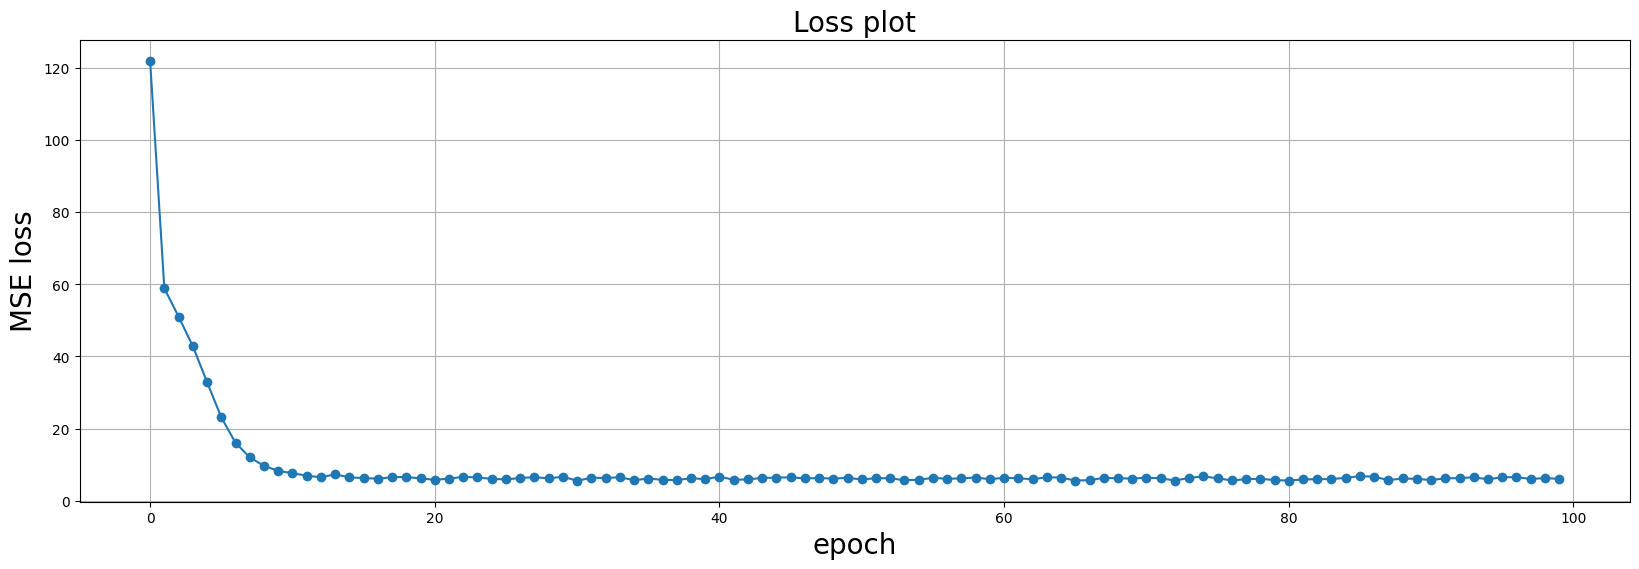

In [23]:
fig = plt.figure(figsize = (20,6 ) )
plt.plot( list_epoch_train_loss, 'o-'  )
plt.title('Loss plot', fontsize = 20 )
plt.xlabel('epoch',fontsize = 20 )
plt.ylabel('MSE loss', fontsize=20)
plt.grid()
plt.show()

In [24]:
%%time
def convert_to_numpy( v1,v2 ):
    if isinstance(v1, torch.Tensor):
        #print('torch')
        v1np = v1.detach().cpu().numpy().reshape(-1,)
    else:
        v1np = v1.reshape(-1,)
    if isinstance(v2, torch.Tensor):
        v2np = v2.detach().cpu().numpy().reshape(-1,)        
    else:
        v2np = v2.reshape(-1,)  
    return v1np,v2np

CPU times: total: 0 ns
Wall time: 0 ns


## Basic statistics on unseen data

In [25]:
%%time
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


X_test, y_test = random_walks(list_generators, n_random_walk_length=n_random_walk_length, 
                                n_random_walks_to_generate= 1024, # n_random_walks_to_generate, 
                                n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban, 
                                random_walks_type = random_walks_type, # 'simple', 
                                state_rw_start = state_destination)

batch_size = 1024 
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

t0 = time.time()
model.eval()
y_pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch_X = batch[0].to(device)
        batch_pred = model(batch_X)
        y_pred_list.append(batch_pred.detach().cpu())
predict_time = time.time() - t0

y_pred = torch.cat(y_pred_list).numpy()
y_test = y_test.detach().cpu().numpy()
# y_test, y_pred = convert_to_numpy( y_test, y_pred)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
spearmanr_test = stats.spearmanr(y_test, y_pred).statistic
#res.statistic


df_stat = pd.DataFrame()
IX = len(df_stat)+1

df_stat.loc[IX,'Model'] = str_modeling_inf
df_stat.loc[IX,'r2 Test'] = r2_test
#df_stat.loc[IX,'r2 Train'] = r2_train
df_stat.loc[IX,'rmse Test'] = rmse_test
#df_stat.loc[IX,'rmse Train'] = rmse_train
df_stat.loc[IX,'Spearman Test'] = spearmanr_test
#df_stat.loc[IX,'Spearman Train'] = spearmanr_train
#df_stat.loc[IX,'FitTime'] = np.round(fit_time,3)
df_stat.loc[IX,'PredictTime'] = np.round(predict_time,3)
#df_stat.loc[IX,'Train'] = str(X_train.shape)
df_stat.loc[IX,'Test'] = str(X_test.shape)

df_stat.round(3)

TypeError: got an unexpected keyword argument 'squared'

## Predictions vs steps

<timed exec>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


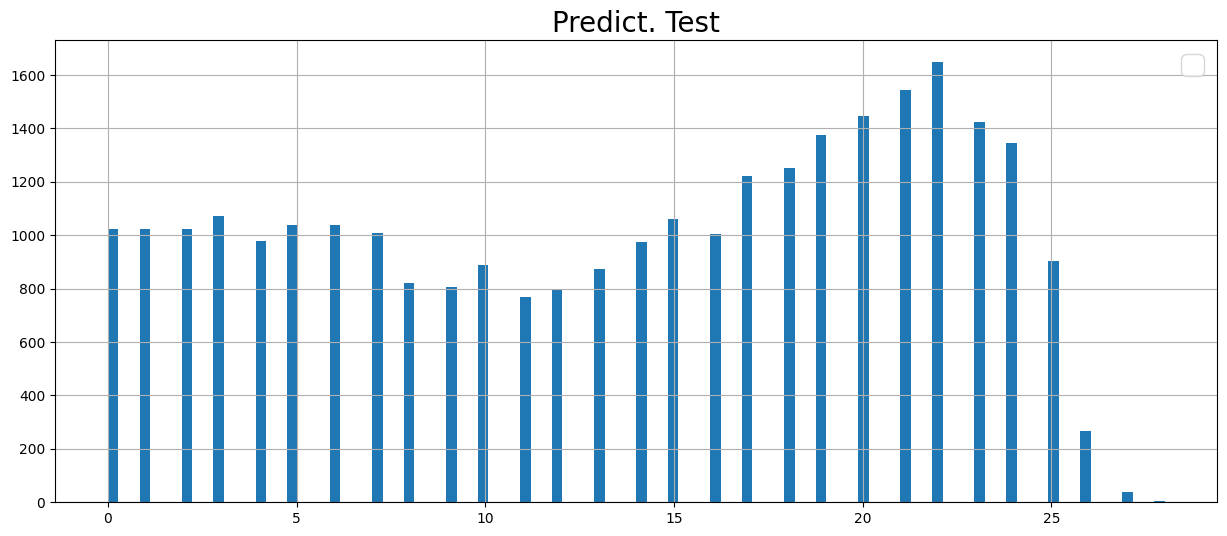

<timed exec>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


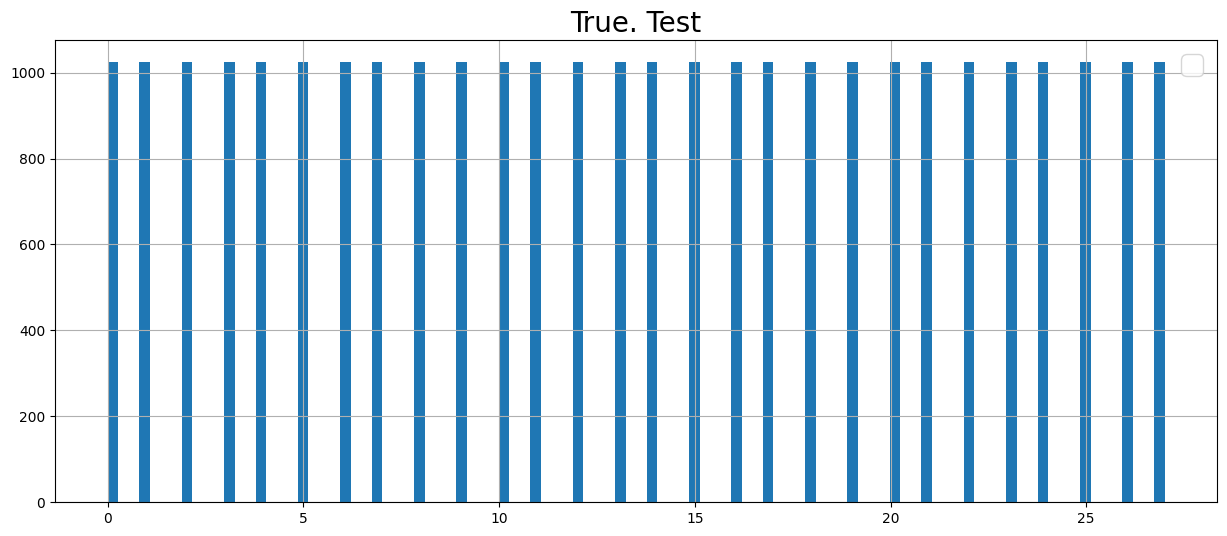

CPU times: total: 469 ms
Wall time: 451 ms


In [26]:
%%time 
y_true = y_test

plt.figure(figsize=(15,6))
plt.hist(np.round(y_pred), bins = 100)
# plt.hist( y_pred, bins = 100)
plt.title('Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.hist(y_true, bins = 100)
plt.title('True. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

## Predictions vs steps

<timed exec>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


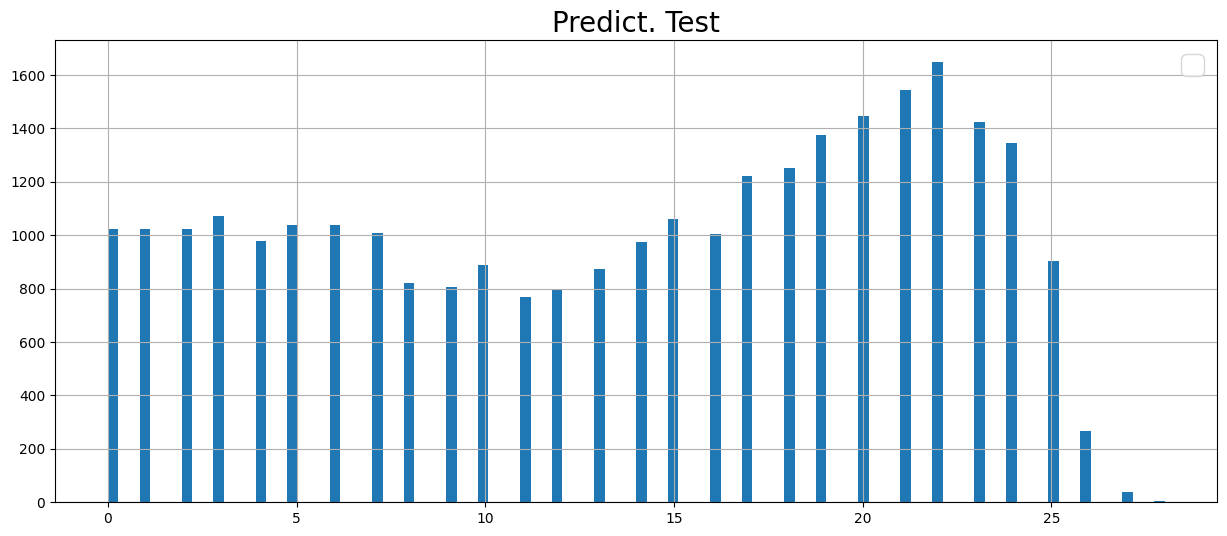

<timed exec>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


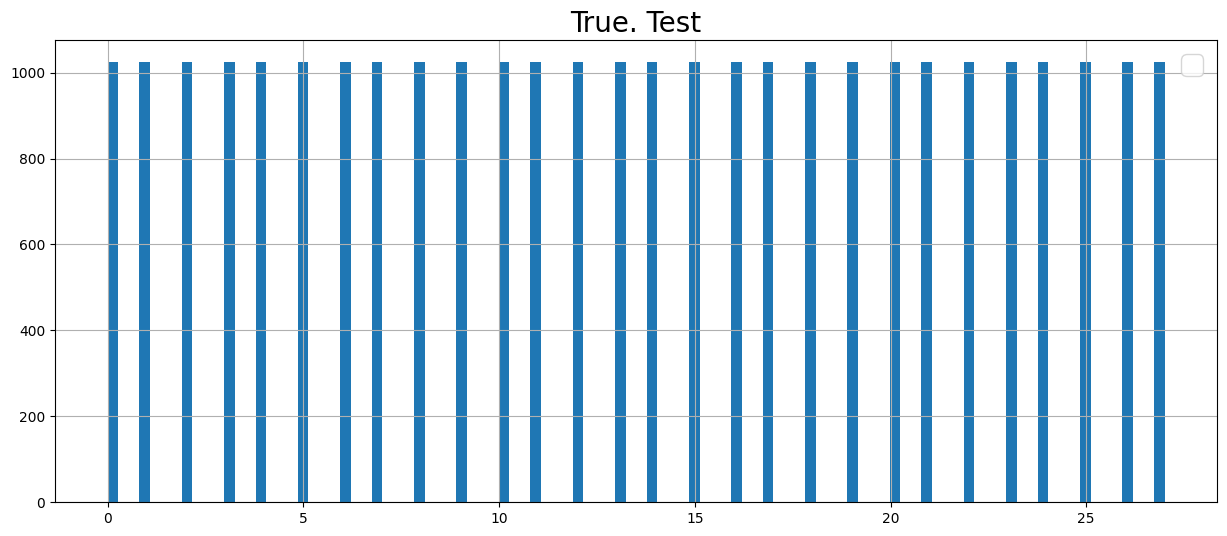

CPU times: total: 328 ms
Wall time: 313 ms


In [27]:
%%time 
y_true = y_test

plt.figure(figsize=(15,6))
plt.hist(np.round(y_pred), bins = 100)
# plt.hist( y_pred, bins = 100)
plt.title('Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.hist(y_true, bins = 100)
plt.title('True. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

## Mean-error plot

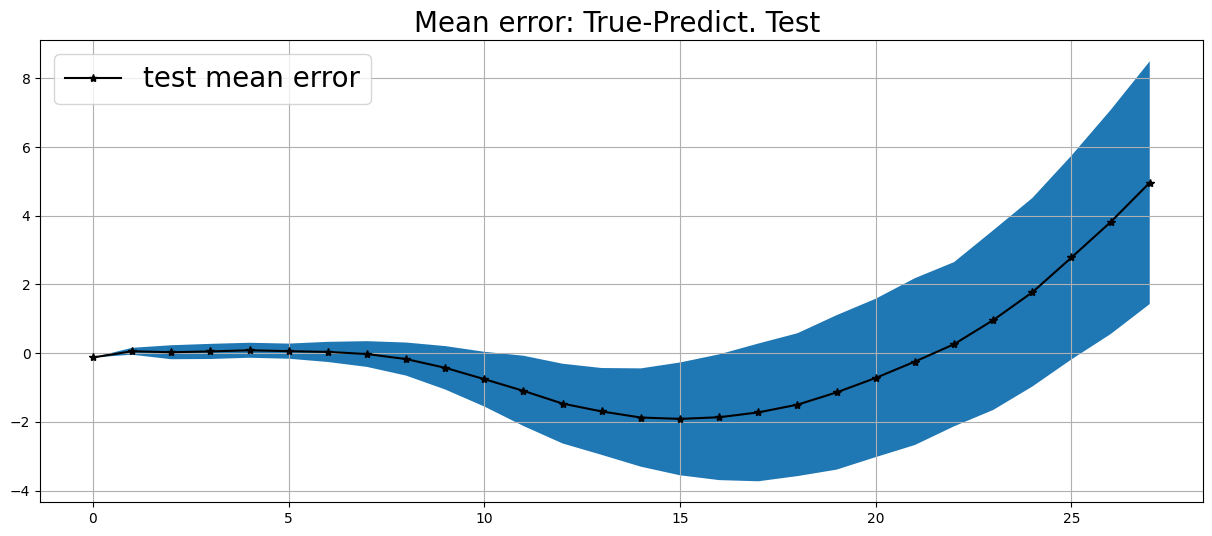

CPU times: total: 109 ms
Wall time: 117 ms


In [28]:
%%time 
list_uv = np.unique(y_test)

y_true = y_test
y_pred = y_pred.reshape(-1,)
df1 = pd.DataFrame()
for k in list_uv:
    mask = y_true == k
    er = np.mean(y_true[mask]- y_pred[mask])
    st = np.std(y_true[mask]- y_pred[mask])
    df1.loc[k,'mean error'] = np.mean(er)
    df1.loc[k,'std'] = st
    
x = df1.index
y = df1['mean error'].values
error =  df1['std'].values
plt.figure(figsize=(15,6))
plt.plot(x,y ,'k*-',  label = 'test mean error')
plt.fill_between(x, y-error, y+error)

plt.title('Mean error: True-Predict. Test ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

## Error histogram

<timed exec>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


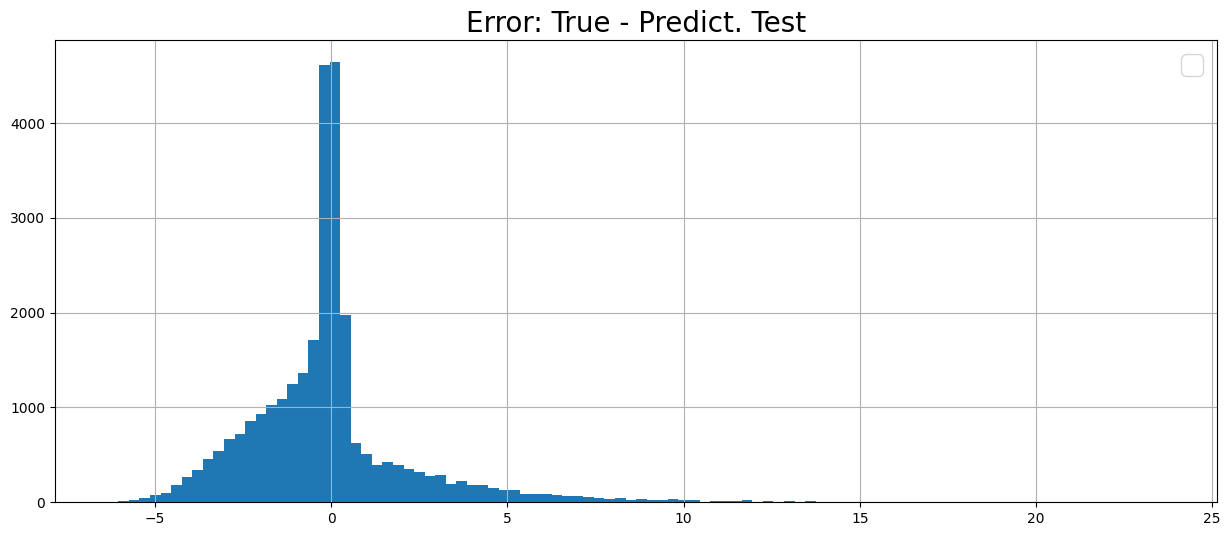

,Test Error,Test Predict
count,28672.000,28672.000
mean,-0.066,13.566
std,2.436,7.764
min,-6.347,0.125
25%,-1.288,6.402
50%,-0.125,14.703
75%,0.313,20.507
max,23.648,28.275


CPU times: total: 156 ms
Wall time: 172 ms


In [29]:
%%time
df1 = pd.DataFrame()

y_true = y_test
er = y_true - y_pred
df1['Test Error'] = er
df1['Test Predict'] = y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


er_stat = df1.describe().round(3)
display(er_stat)
er_stat.to_csv('error_stat.csv')

## Predictions on few trajectories

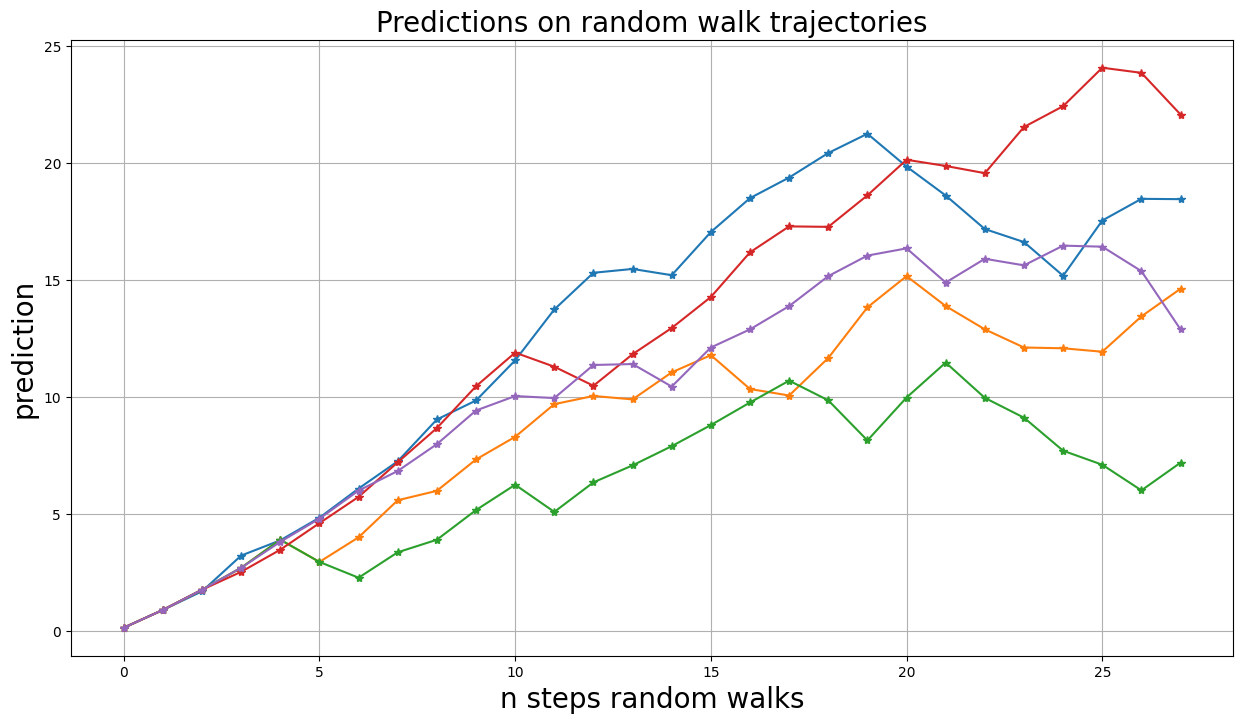

CPU times: total: 250 ms
Wall time: 298 ms


In [30]:
%%time 
plt.figure(figsize=(15,8))

for _ in range(5):
    X_test, y_test = random_walks(list_generators, n_random_walk_length=n_random_walk_length, 
                                    n_random_walks_to_generate=1, 
                                    n_random_walks_steps_back_to_ban = 10, random_walks_type =  'non-backtracking-beam', # 'simple', 
                                    state_rw_start = state_destination)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    y_test , y_pred =  convert_to_numpy( y_test  ,y_pred ) 
    
    
    plt.plot(y_pred, '*-' )
plt.title('Predictions on random walk trajectories', fontsize = 20)
# plt.legend(fontsize = 20 )
plt.xlabel('n steps random walks', fontsize = 20)
plt.ylabel('prediction', fontsize = 20  )
plt.grid()
plt.show()

# BFS compute distances 


Torch implementation - see more details in: https://www.kaggle.com/code/alexandervc/growth-4simple-permutations-torch-gpu/ 


PS

More profound versions: https://www.kaggle.com/code/alexandervc/growth-4batched-permutations-torch-gpu,

Torch: https://www.kaggle.com/code/alexandervc/growth-3-permutations-torch-gpu, support 1 billion draft: https://www.kaggle.com/code/alexandervc/growth-4draft-permutations-torch-gpu

Previous version based on numpy: https://www.kaggle.com/code/alexandervc/growth-2-permutations-with-numpy

That is originally proposed during Santa challenge - see notebook: https://www.kaggle.com/code/alexandervc/santa23-states-distance-generate-save

For matrix groups - we need one more trick for hashing: https://www.kaggle.com/code/alexandervc/groups-growth-fast-compute-heisenberg

More complicated with using disk and batches: https://www.kaggle.com/code/alexandervc/groups-growth-fast-compute-ut5-6-7-8-etc

In [31]:
def get_unique_elements_first_idx(tensor, stable = True ):
    '''
    Returns indices of the unique elements in tensor - taking 
    
    https://stackoverflow.com/a/78807335/625396
    '''
    
    # sort tensor
    sorted_tensor, indices = torch.sort(tensor, stable = stable )
    # find position of jumps
    unique_mask = torch.cat((torch.tensor([True], device = tensor.device), sorted_tensor[1:] != sorted_tensor[:-1]))
    return indices[unique_mask], sorted_tensor[unique_mask]

In [32]:
%%time
def bfs_growth_permutations_torch_simple(generators, # Generators ("moves") defining Cayley graph - list (or array) of permutations (or matrices) 
        center_states = None, # State(s) from which bfs is started, Default: 0,1,2,3,... 
        radius_max = 10000, # Maximul radius to compute, for huge graph and large radius - RAM crashes  
        stop_threshold_total_states = np.inf, # Stop exceeding these threshold in total states                           
        device = None, # device for tensors like GPU or CPU - not used in numpy version
        dtype = None, # datatype for small groups uint8, typically unint16
        vec_hasher  = None, # vector to create hashes, if None will be generated 
        flag_return_all_hashes = True, # return all hashes - a bit more RAM
        flag_return_all_states = True,  # return all constrcuted states - more RAM consumption
        flag_return_list_distances = True, # return list of distances  of all constructed states - a bit more RAM
        verbose = 0, # verbosity 
        ):
    t0 = time.time()
    
    '''
    Run bfs to visit all states on distance <= radius_max from center_states.
    For the Cayley-type graph defined by the generator permutations (input: "generators"),
    and initial state(s) (input: center_states) - default is identity permutation, 
    but we support any input state(s). Thus we cat contstruct Cayley-Schreier coset graphs. 
    
    
    Parameters:
        generators - generators ("moves") defining the Cayley graph, each generator is permutation,
                    can be list of vectors or matrix with each row is vector
        center_states = None, # State(s) from which bfs is started, Default: 0,1,2,3,... 
        radius_max = 10000, # Maximul radius to compute, for huge graph and large radius - RAM crashes  
        device = None, # device for tensors like GPU or CPU - not used in numpy version
        dtype = None, # datatype to store states:  for small groups - uint8, for bigger: uint16
        vec_hasher  = None, # vector to create hashes, if None will be generated 
        flag_return_all_hashes = True, # return all hashes - a bit more RAM
        flag_return_all_states = True,  # return all constrcuted states - more RAM consumption
        flag_return_list_distances = True, # return list of distances  of all constructed states - a bit more RAM
        verbose = 0, # verbosity 
    
    Returns:
        dict_growth - dictionary with 
        dict_additional_data - optional, contains the following:
            vec_hasher  - vector to create hashes (torch tensor)
            list_distances - list distances for each state - same order of states as for hashes, states 
            vec_hashes_all - all hashes of obtained states
            array_states_all - all states 

    That function is calling lower level subfunctions depending on engine and generators type - permutations or matrices
    '''

    ##########################################################################################
    # Analyse input params and convert to stadard forms
    ##########################################################################################
    generators_type = 'permutation' # 'matrix'
    
    # device 
    if device is None:
#         if (center_states is not None) and hasattr(center_states, 'dtype'):
#             device = center_states.device
#         else:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    
    
    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]       
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators"')
    state_size = len(list_generators[0])
    tensor_all_generators = torch.tensor( list_generators , device = device, dtype = torch.int64)

    # dtype 
    if dtype is None:
        if isinstance(center_states, torch.Tensor ):
            dtype = center_states.dtype
        else:
            if state_size <= 256:
                dtype = torch.uint8
            else:
                dtype = torch.uint16  
                
    # Center state(s)
    if center_states is None:
        center_states = torch.arange( state_size, device=device, dtype = dtype).reshape(1,state_size)
    if not isinstance( center_states , torch.Tensor):
        center_states = torch.tensor( center_states  )
    center_states = center_states.reshape(-1,state_size).to(device)
    
    # Vec_hasher
    if vec_hasher is None:
        # Hash vector generation
        max_int =  int( (2**62) )     #print(max_int)
        dtype_for_hash = torch.int64
        vec_hasher = torch.randint(-max_int, max_int,   size= (state_size,),  device=device, dtype = dtype_for_hash) #
    if not isinstance( vec_hasher , torch.Tensor):
        vec_hasher = torch.tensor( vec_hasher , device=device, dtype = dtype_for_hash )
    
    
    ###################################################################################
    # Prepare output data: 
    ###################################################################################
    # Main output: Growth - dictionary: distance-> how many states
    dict_growth = {0: center_states.shape[0]}
    # Secondary output:
    dict_additional_data = {}
    dict_additional_data['vec_hasher'] = vec_hasher
    # Hashes:
    vec_hashes_all = torch.tensor([], device = device, dtype = vec_hasher.dtype ) # Defined later
    # Distances 
    list_distances = [0]*center_states.shape[0]
    # States  
    array_states_all = center_states.clone()
    
    ##################################################################################
    # Used in process:
    ##################################################################################
    # States 
    array_states_achieved_previous_step = center_states.clone()
    
    # Hashes
    dtype_for_hash = vec_hasher.dtype
    vec_hashes_all = torch.sum(array_states_achieved_previous_step * vec_hasher, dim=1) # Compute hashes. 
        # It is same as matrix product torch.matmul(hash_vec , states ) 
        # but pay attention: such code work with GPU for integers 
        # While torch.matmul - does not work for GPU for integer data types, 
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication 
    vec_hashes_previous_step = vec_hashes_all.clone() # Compute hashes. 
    vec_hashes_pre_previous_step = vec_hashes_all.clone()
    vec_hashes_current = vec_hashes_all.clone()
    
    
    ###############################################################################################
    # Main loop over distances:
    ###############################################################################################
    for i_distance in range(1,radius_max+1):
        t_moves = t_hash = t_isin = t_unique_els = 0; t_all = time.time() # Time profiling
        
        # Apply generator to all current states 
        t1 = time.time()
        new_states_candidates = get_neighbors(  array_states_achieved_previous_step ,  tensor_all_generators.to(torch.int64) ).flatten(end_dim=1)
        t_moves += (time.time() - t1)
        
        # Compute hash
        # That can cause RAM crash ! Because new_states_candidates * vec_hasher is created, it will be int64 - so 8 times larger than new_states_candidates
        t1 = time.time()
        vec_hashes_new_all_gens = torch.sum(new_states_candidates * vec_hasher, dim=1) # Compute hashes 
            # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        t_hash += (time.time() - t1)        
        
        # Select unique
        t1 = time.time()
        unique_idx,unique_hashes = get_unique_elements_first_idx(vec_hashes_new_all_gens,  stable = False )
        t_unique_els += (time.time() - t1)

        # Select new 
        t1 = time.time()
        mask_new = ~torch.isin(unique_hashes, vec_hashes_current, assume_unique=True)
        t_isin += (time.time() - t1)
        #######################################################
        # End of main operations.
        #######################################################

        n_new_states = mask_new.sum().item()
        # Check Growth finished - no new states can be found:
        if n_new_states == 0: break            
        
        #######################################################
        # Prepare data for the next loop iteration: 
        #######################################################
        
        # Store new states 
        array_new_states = new_states_candidates[unique_idx, : ][mask_new,:]
        array_states_achieved_previous_step = array_new_states

        # Hashes 
        vec_hashes_new_all_gens = unique_hashes[mask_new]
        vec_hashes_pre_previous_step = vec_hashes_previous_step
        vec_hashes_previous_step = vec_hashes_new_all_gens
        vec_hashes_current = torch.cat([vec_hashes_pre_previous_step, vec_hashes_previous_step], dim = 0 )
        
        ###############################################################################
        # Update output data :
        ##############################################################################
        dict_growth[i_distance] = n_new_states       
        if flag_return_list_distances: # return list of distances  of all constructed states - a bit more RAM
            list_distances += [i_distance] * int(array_new_states.shape[0])

        if flag_return_all_hashes: # return all hashes - a bit more RAM consumption
            vec_hashes_all = torch.cat([vec_hashes_all, vec_hashes_new_all_gens], dim = 0  ) 
            #print('vec_hashes_all.shape:', vec_hashes_all.shape, vec_hashes_new_all_gens.shape) 

        if flag_return_all_states: # return all constrcuted states - more RAM consumption
            array_states_all = torch.cat([array_states_all, array_new_states], dim = 0  )         
        
        if verbose >= 10:
            t_all = time.time()-t_all
            print(i_distance,'i_distance',n_new_states, 'new states', 
                 't_all %.3f, t_moves  %.4f, t_hash  %.4f, t_isin %.3f, t_unique_els  %.3f, '%(t_all,t_moves , 
                  t_hash , t_isin , t_unique_els), 'Cummulat Time %.3f'%(time.time()-t0), )        
        
        #print( np.sum( list(dict_growth.values()) ))    
        if np.sum( list(dict_growth.values()) ) >= stop_threshold_total_states:
            break
        
    ##########################################################################################
    # Finalize output:
    ##########################################################################################
    if flag_return_all_hashes: # return all hashes - a bit more RAM consumption
        dict_additional_data['vec_hashes_all'] = vec_hashes_all
        
    if flag_return_all_states: # return all constrcuted states - more RAM consumption
        dict_additional_data['array_states_all'] = array_states_all
        
    if flag_return_list_distances: # return list of distances  of all constructed states - a bit more RAM
        dict_additional_data['list_distances'] = list_distances

    return dict_growth, dict_additional_data

def bfs_growth(generators, # Generators ("moves") defining Cayley graph - list (or array) of permutations (or matrices) 
        center_states = None, # State(s) from which bfs is started, Default: 0,1,2,3,... 
        radius_max = 10000, # Maximul radius to compute, for huge graph and large radius - RAM crashes  
        stop_threshold_total_states = np.inf, # Stop exceeding these threshold in total states 
        device = None, # device for tensors like GPU or CPU - not used in numpy version
        dtype = None, # datatype for small groups uint8, typically unint16
        vec_hasher  = None, # vector to create hashes, if None will be generated 
        flag_return_all_hashes = True, # return all hashes - a bit more RAM
        flag_return_all_states = True,  # return all constrcuted states - more RAM consumption
        flag_return_list_distances = True, # return list of distances  of all constructed states - a bit more RAM
        batch_size_states = 1024*1024, # Batch-size for the process. Huge batch may crash RAM 
        verbose = 0, # verbosity 
        work_mode = 'to-do', # several methods with hashes and one without 
        engine = 'torch',# numpy, torch - what engine to use
        ):
    
    dict_growth, dict_additional_data = bfs_growth_permutations_torch_simple(generators, # Generators ("moves") defining Cayley graph - list (or array) of permutations (or matrices) 
        center_states = center_states, # State(s) from which bfs is started, Default: 0,1,2,3,... 
        radius_max = radius_max, # Maximul radius to compute, for huge graph and large radius - RAM crashes  
        stop_threshold_total_states = stop_threshold_total_states, # Stop exceeding these threshold in total states 
        device = device, # device for tensors like GPU or CPU - not used in numpy version
        dtype = dtype, # datatype for small groups uint8, typically unint16
        vec_hasher  = vec_hasher, # vector to create hashes, if None will be generated 
        flag_return_all_hashes = flag_return_all_hashes, # return all hashes - a bit more RAM
        flag_return_all_states = flag_return_all_states,  # return all constrcuted states - more RAM consumption
        flag_return_list_distances = flag_return_list_distances, # return list of distances  of all constructed states - a bit more RAM
        #batch_size_states = batch_size_states, # Batch-size for the process. Huge batch may crash RAM 
        verbose = verbose, # verbosity 
        )
    return dict_growth, dict_additional_data


# Also: https://www.cube20.org/qtm/
# cube_3/3/3_12gensQTM 6_color
# Total: 9205558 growth: {0: 1, 1: 12, 2: 114, 3: 1068, 4: 10011, 5: 93840, 6: 878880, 7: 8221632, 8: 76843595}}
# Growth factors: [12.   9.5  9.4  9.4  9.4  9.4  9.4]
# print(dict_growth )    

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time 

# verbose = 10
# flag_return_all_hashes = True#, # return all hashes - a bit more RAM
# flag_return_all_states = True# False#,  # return all constrcuted states - more RAM consumption
# flag_return_list_distances = True# False#, # return list of distances  of all constructed states - a bit more RAM

radius_max = 30# , # Maximul radius to compute, for huge graph and large radius - RAM crashes  
stop_threshold_total_states = 10**6

# group_gens_id = 'cube_2/2/2_6gensQTM' # group_gens_id = 'cube_2/2/2'#_6gensQTM' 
# #group_gens_id = 'cube_3/3/3_12gensQTM'
# list_generators = list( get_dict_generators( group_gens_id ).values() )

dict_growth, dict_additional_data = bfs_growth(list_generators, 
                           center_states =  state_destination,        
                           radius_max = radius_max, 
                           stop_threshold_total_states = stop_threshold_total_states, # Stop exceeding these threshold in total states 
                           flag_return_all_states = True, flag_return_all_hashes = True, flag_return_list_distances = True,
                           device = device, dtype = dtype,
                           vec_hasher = vec_hasher,  verbose = 10 )

array_states_all_saved =  dict_additional_data['array_states_all']
list_distances_save = dict_additional_data['list_distances']

print()
print('Result - dict_growth:')
print(dict_growth)
print('Total states:', np.sum( list(dict_growth.values()) ))
print()

# 'cube_2/2/2_6gensQTM'
# Total: 3674160 growth: 
# {0: 1, 1: 6, 2: 27, 3: 120, 4: 534, 5: 2256, 6: 8969, 7: 33058, 8: 114149, 9: 360508, 10: 930588, 11: 1350852, 12: 782536, 13: 90280, 14: 276}
# https://en.wikipedia.org/wiki/Pocket_Cube

print('Result - dict_additional_data - keys:')
print(dict_additional_data.keys() ) # ['vec_hasher', 'vec_hashes_all', 'array_states_all', 'list_distances']
print()

print('vec_hasher')
print(dict_additional_data['vec_hasher']) 
print()

print('list_distances 100 first: ')
print(dict_additional_data['list_distances'][:100]) 
print()

print('vec_hashes_all  5 first: ')
print(dict_additional_data['vec_hashes_all'][:5]) 
print()

print('array_states_all 2 first:')
print(dict_additional_data['array_states_all'][:2,:]) 
print()

1 i_distance 3 new states t_all 0.009, t_moves  0.0000, t_hash  0.0010, t_isin 0.007, t_unique_els  0.000,  Cummulat Time 0.010
2 i_distance 6 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.012
3 i_distance 12 new states t_all 0.003, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.015
4 i_distance 23 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.017
5 i_distance 44 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.019
6 i_distance 80 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.021
7 i_distance 142 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.000, t_unique_els  0.001,  Cummulat Time 0.023
8 i_distance 247 new states t_all 0.002, t_moves  0.0000, t_hash  0.0000, t_isin 0.001, t_unique_e

In [34]:
print('array_states_all_saved.shape',array_states_all_saved.shape)
print('array_states_all_saved first 5:',array_states_all_saved[:5,:])
print()
print('len(list_distances_save)',len(list_distances_save) )
print('list_distances_save first 10:',list_distances_save[:10] )

array_states_all_saved.shape torch.Size([40320, 8])
array_states_all_saved first 5: tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 0, 2, 3, 4, 5, 6, 7],
        [7, 0, 1, 2, 3, 4, 5, 6],
        [2, 1, 3, 4, 5, 6, 7, 0]], device='cuda:0')

len(list_distances_save) 40320
list_distances_save first 10: [0, 1, 1, 1, 2, 2, 2, 2, 2, 2]


## Slow simple growth computation 

In [35]:
%%time 
def get_hash(state):
    return hash( str(state) ) # do not use tuple(state) - it produce different hashes for same states

t1 = time.time()
state_initial = state_destination
list_growth = [1] # 1 state on distance 0
list_all_states = [ state_initial]
list_current_states = [ state_initial]
list_distances = [0]
set_hash = set();  set_hash.add(  get_hash(state_initial )  )

for depth in range(1, 500):
    list_new_states = []
    for g in list_generators:
        for s in list_current_states:
            new_state = s[g]
            
            # print(type(new_state));break
            h = get_hash(new_state)
            if h not in set_hash:
                set_hash.add( h  )
                list_new_states.append(new_state)
                #print(new_state, h)
    if len(list_new_states) == 0: break
    list_all_states +=   list_new_states   
    list_growth.append( len(list_new_states ))
    list_distances += [ depth ] * len(list_new_states )
    list_current_states = list_new_states
    print('depth',depth,'n_new_states:',len(list_new_states ), 'Time %.1f'%(time.time() - t1)  )
    if len(list_all_states) >= 10**3: break 
        
print('sum:', np.sum(list_growth ))
print( list_growth     )

depth 1 n_new_states: 3 Time 0.0
depth 2 n_new_states: 6 Time 0.0
depth 3 n_new_states: 12 Time 0.0
depth 4 n_new_states: 23 Time 0.1
depth 5 n_new_states: 44 Time 0.1
depth 6 n_new_states: 80 Time 0.2
depth 7 n_new_states: 142 Time 0.3
depth 8 n_new_states: 247 Time 0.5
depth 9 n_new_states: 411 Time 0.8
depth 10 n_new_states: 662 Time 1.4
sum: 1631
[1, 3, 6, 12, 23, 44, 80, 142, 247, 411, 662]
CPU times: total: 1.38 s
Wall time: 1.42 s



# Predictions vs true distances 

<timed exec>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
<timed exec>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


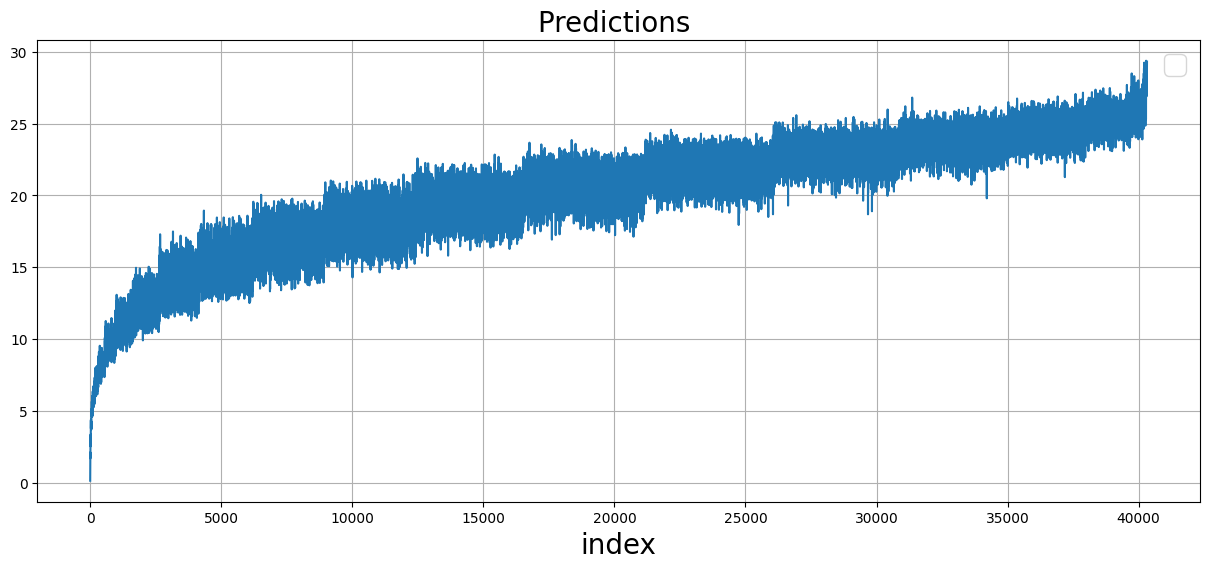

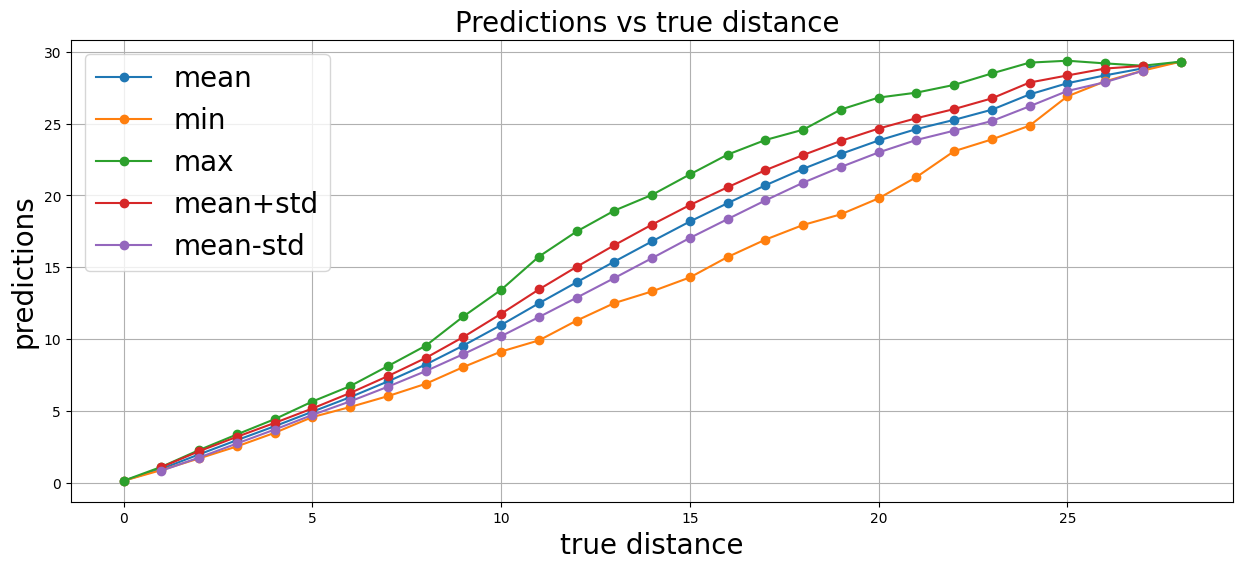

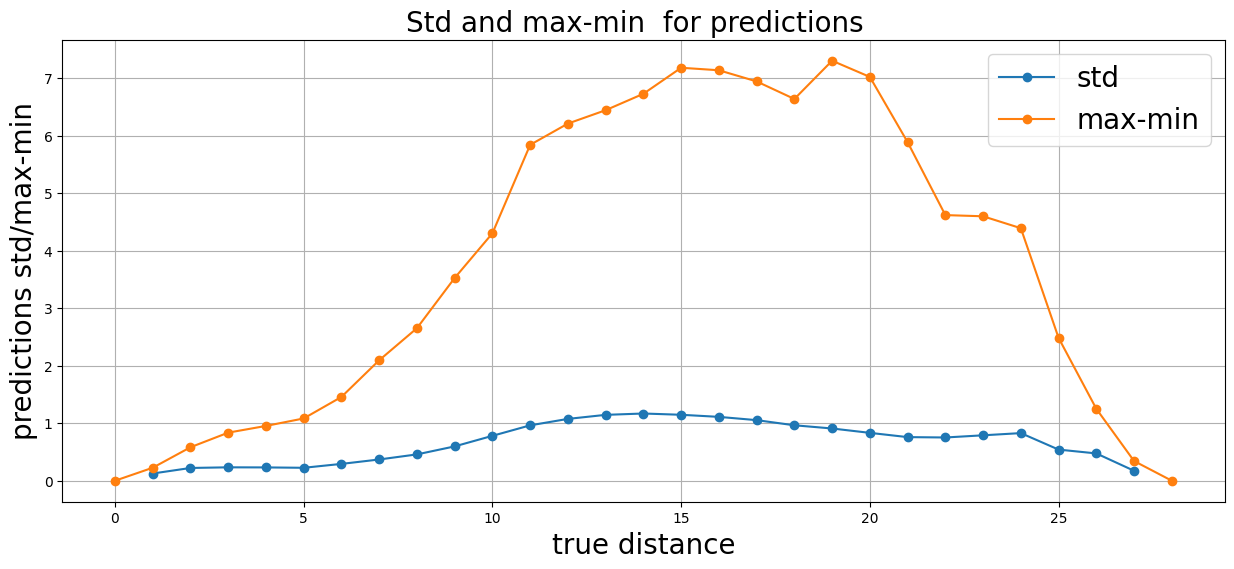

<timed exec>:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


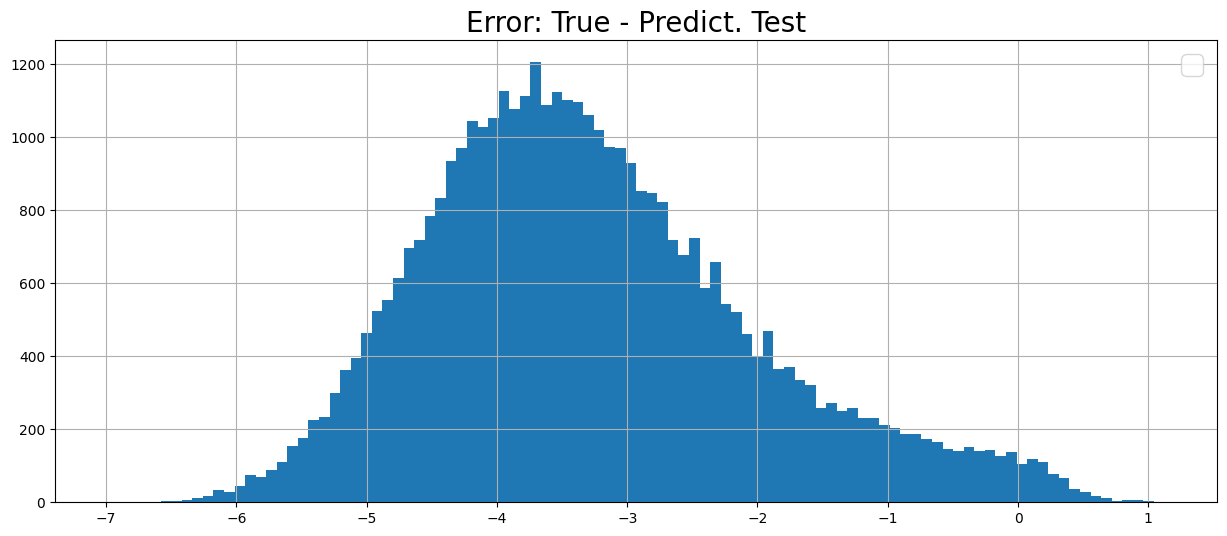

TypeError: got an unexpected keyword argument 'squared'

In [36]:
%%time
# all_states = torch.zeros( size = (len(list_all_states), list_all_states[0].shape[0] ),  dtype =dtype, device = device )
# for k in range(len(list_all_states)):
#     all_states[k,:] = list_all_states[k]

all_states = array_states_all_saved
list_distances = list_distances_save

# model.eval()
# with torch.no_grad():
#     y_pred = model(all_states)
batch_size = 1024 

all_states_tensor = torch.tensor(all_states, dtype=torch.float32)
dataset = TensorDataset(all_states_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Batched prediction
model.eval()
y_pred_list = []

with torch.no_grad():
    for batch in dataloader:
        batch_states = batch[0].to(device)
        batch_pred = model(batch_states)
        y_pred_list.append(batch_pred.detach().cpu())

y_pred = torch.cat(y_pred_list).numpy().ravel()
y_test = np.array(list_distances)

# y_pred = y_pred.detach().cpu().numpy().ravel() #  =  convert_to_numpy( y_pred  ,y_pred ) 
# y_test = np.array( list_distances )

plt.figure(figsize=(15,6))
plt.plot(y_pred )
plt.title('Predictions ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('index',fontsize = 20 )
plt.grid()
plt.show()

d = pd.DataFrame()
d['pred'] = y_pred
d['true'] = y_test
res = d.groupby('true')['pred'].agg(['mean', 'min', 'max'])
st = d.groupby('true')['pred'].agg(['std'])
plt.figure(figsize=(15,6))
plt.plot(res, 'o-',label = res.columns )
plt.plot(res['mean']+st['std'], 'o-',label = 'mean+std' )
plt.plot(res['mean']-st['std'], 'o-',label = 'mean-std' )
plt.title('Predictions vs true distance ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions',fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(st['std'], 'o-', label = 'std' )
plt.plot(res['max']-res['min'],'o-', label = 'max-min' )
plt.title('Std and max-min  for predictions  ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions std/max-min',fontsize = 20 )
plt.grid()
plt.show()


y_true = y_test
er = y_true - y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
spearmanr_test = stats.spearmanr(y_test, y_pred).statistic
pearson_test = np.corrcoef(y_test, y_pred)[0,1]
#res.statistic


df_stat = pd.DataFrame()
IX = len(df_stat)+1

df_stat.loc[IX,'Model'] = str_modeling_inf
# df_stat.loc[IX,'r2 Test'] = r2_test
#df_stat.loc[IX,'r2 Train'] = r2_train
# df_stat.loc[IX,'rmse Test'] = rmse_test
#df_stat.loc[IX,'rmse Train'] = rmse_train
df_stat.loc[IX,'Spearman'] = spearmanr_test
df_stat.loc[IX,'Pearson'] = pearson_test
#df_stat.loc[IX,'Spearman Train'] = spearmanr_train
#df_stat.loc[IX,'FitTime'] = np.round(fit_time,3)
df_stat.loc[IX,'PredictTime'] = np.round(predict_time,3)
#df_stat.loc[IX,'Train'] = str(X_train.shape)
df_stat.loc[IX,'Test'] = str(X_test.shape)

df_stat.round(3)

# Q-learning (one step) i.e. Bellman's equation  - demo example 

Demo example - take all states computed by BFS and apply Q-learning/Bellman's update rule -- 
typically we expect small improvement of correlations Peason/Spearmen with true values.

The price is computing models inference - which might be costly. 

    Bellman's equation for value function on graph:
    V(g) = 1 + min_{neigb} V (neigb )

In our case value function are predictions of the neural network. 



<timed exec>:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


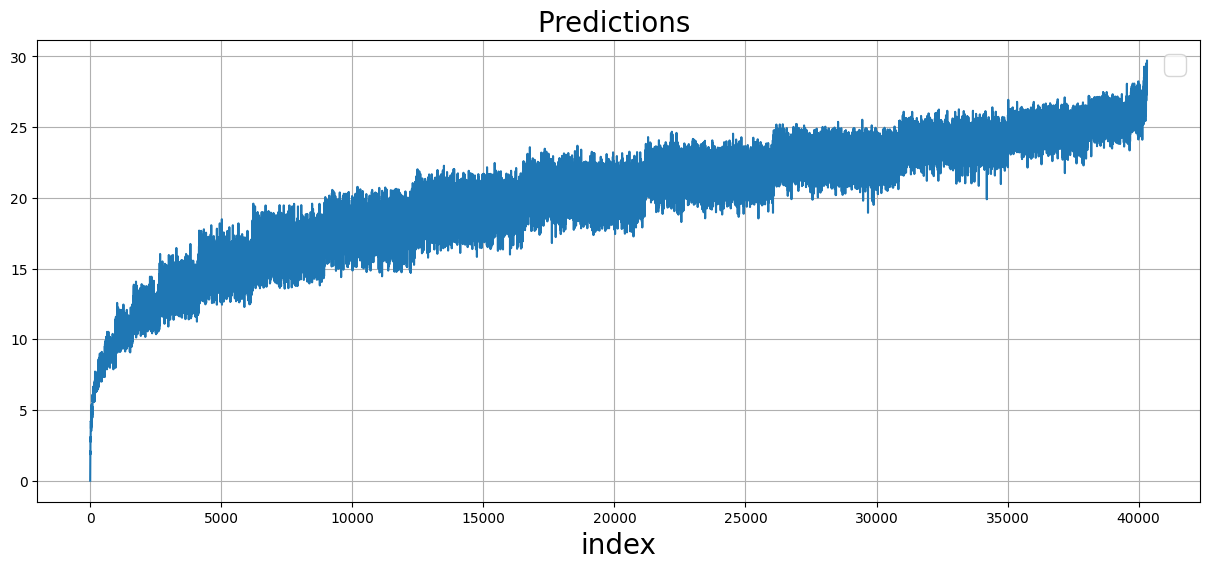

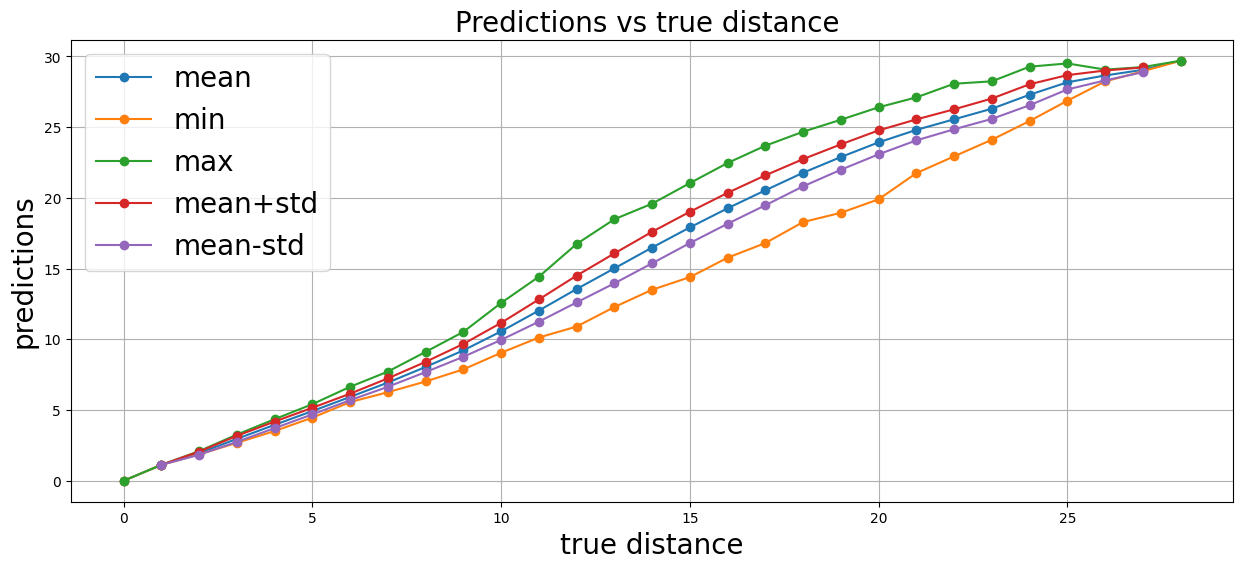

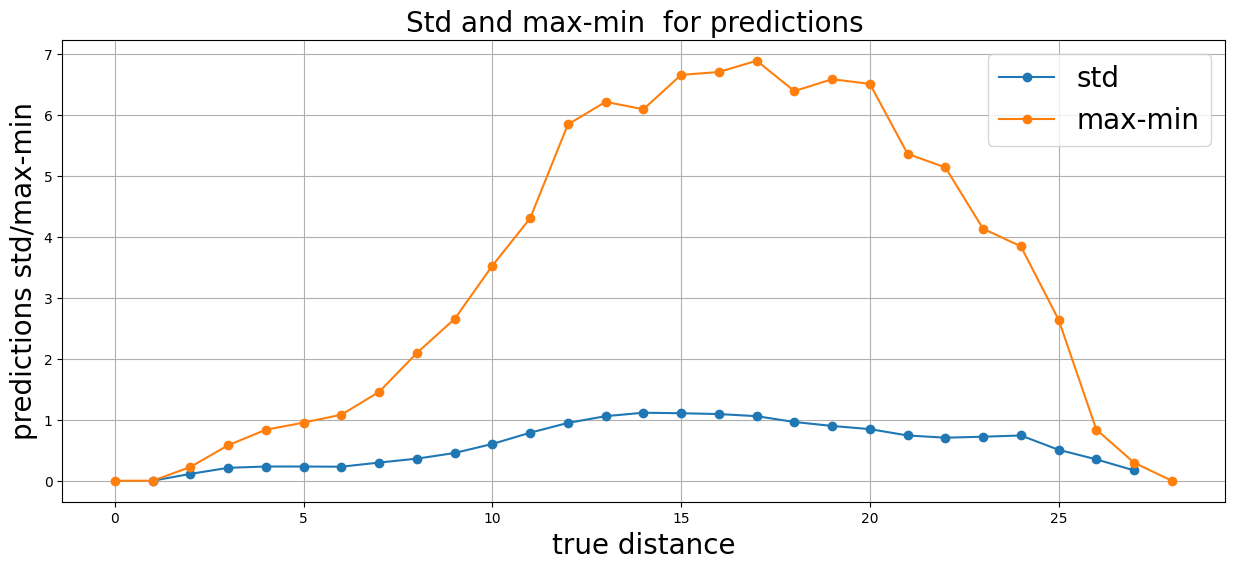

<timed exec>:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


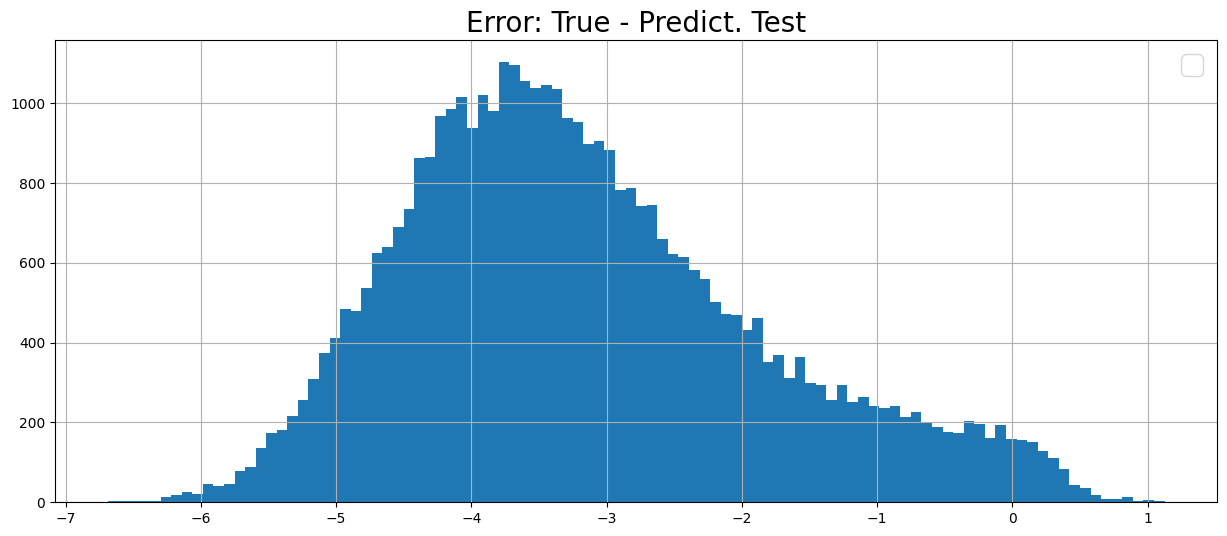

TypeError: got an unexpected keyword argument 'squared'

In [37]:
%%time

# # Take all states constructed by BFS - convert them to torch tensor
# all_states = torch.zeros( size = (len(list_all_states), list_all_states[0].shape[0] ),  dtype =dtype, device = device )
# for k in range(len(list_all_states)):
#     all_states[k,:] = list_all_states[k]


all_states = array_states_all_saved
list_distances = list_distances_save
    
# Compute their neigbours
neigb = get_neighbors(all_states, tensor_generators)
# print( neigb.shape )
      
# Compute model predictions
y_pred = torch.zeros( (neigb.shape[0],neigb.shape[1],1 ), device =device   )
batch_size_loc = 1024
model.eval()
with torch.no_grad():
    for i_batch in range(0,neigb.shape[0], batch_size_loc ):
        i_end_batch = min( [i_batch+batch_size_loc ,neigb.shape[0]] )
        y_pred[i_batch:i_end_batch,:,:] = model(neigb[i_batch:i_end_batch,:,:])# .view(-1, 8) )
# print( y_pred.shape )

# Bellman's equation / Q-learning for graphs update: 
# V(g) = 1 + min_{neigb} V (neigb ) 
y_pred = 1 + torch.min(y_pred, dim=1)[0]

# Clip everthing to 1 and origin to 0
y_pred = torch.clamp_min(y_pred, 1 ) 
# Boundary condition - origin is in zero: 
y_pred[0]=0

# y_pred = torch.round(y_pred)



#######################################################################################
# Plots for error analysis
#######################################################################################

y_pred = y_pred.detach().cpu().numpy().ravel() #  =  convert_to_numpy( y_pred  ,y_pred ) 
y_test = np.array( list_distances )

plt.figure(figsize=(15,6))
plt.plot(y_pred )
plt.title('Predictions ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('index',fontsize = 20 )
plt.grid()
plt.show()

d = pd.DataFrame()
d['pred'] = y_pred
d['true'] = y_test
res = d.groupby('true')['pred'].agg(['mean', 'min', 'max'])
st = d.groupby('true')['pred'].agg(['std'])
plt.figure(figsize=(15,6))
plt.plot(res, 'o-',label = res.columns )
plt.plot(res['mean']+st['std'], 'o-',label = 'mean+std' )
plt.plot(res['mean']-st['std'], 'o-',label = 'mean-std' )
plt.title('Predictions vs true distance ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions',fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(st['std'], 'o-', label = 'std' )
plt.plot(res['max']-res['min'],'o-', label = 'max-min' )
plt.title('Std and max-min  for predictions  ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions std/max-min',fontsize = 20 )
plt.grid()
plt.show()

y_true = y_test
er = y_true - y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
spearmanr_test = stats.spearmanr(y_test, y_pred).statistic
pearson_test = np.corrcoef(y_test, y_pred)[0,1]
#res.statistic


df_stat = pd.DataFrame()
IX = len(df_stat)+1

df_stat.loc[IX,'Model'] = str_modeling_inf
# df_stat.loc[IX,'r2 Test'] = r2_test
#df_stat.loc[IX,'r2 Train'] = r2_train
# df_stat.loc[IX,'rmse Test'] = rmse_test
#df_stat.loc[IX,'rmse Train'] = rmse_train
df_stat.loc[IX,'Spearman'] = spearmanr_test
df_stat.loc[IX,'Pearson'] = pearson_test
#df_stat.loc[IX,'Spearman Train'] = spearmanr_train
#df_stat.loc[IX,'FitTime'] = np.round(fit_time,3)
df_stat.loc[IX,'PredictTime'] = np.round(predict_time,3)
#df_stat.loc[IX,'Train'] = str(X_train.shape)
df_stat.loc[IX,'Test'] = str(X_test.shape)

df_stat.round(3)

## Check effect of "round" (distnaces are integers) - does not seem to improve

<timed exec>:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


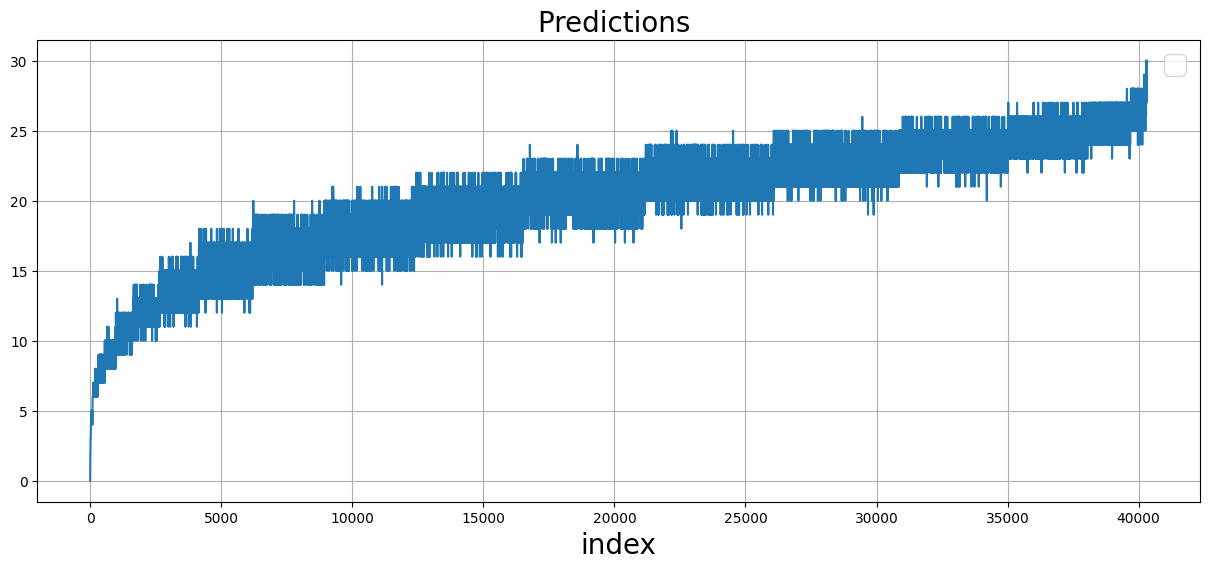

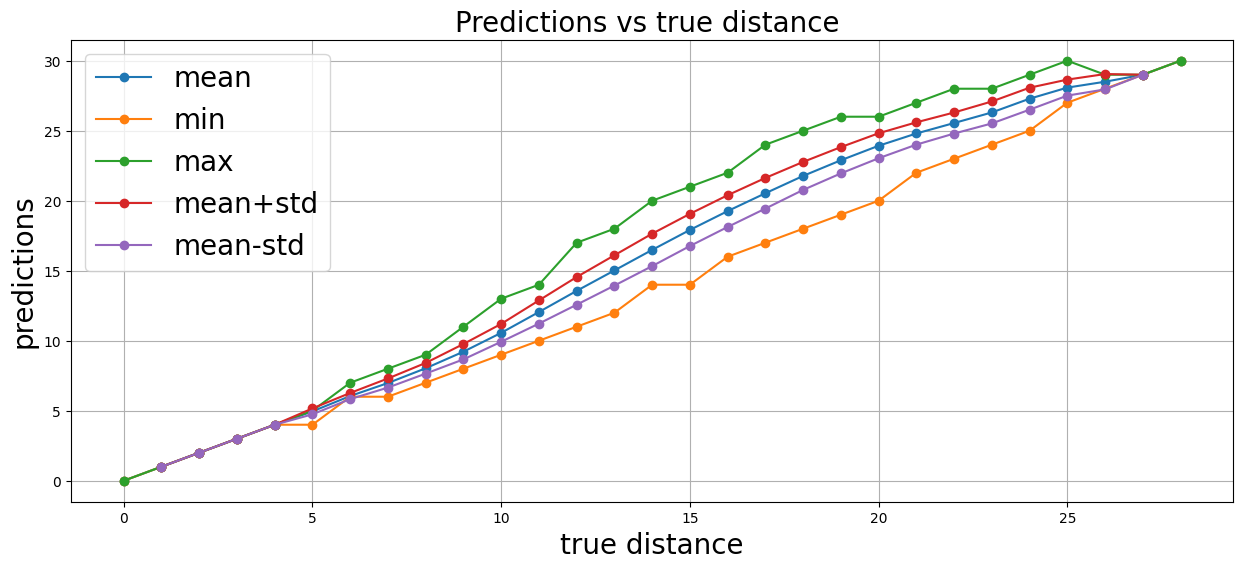

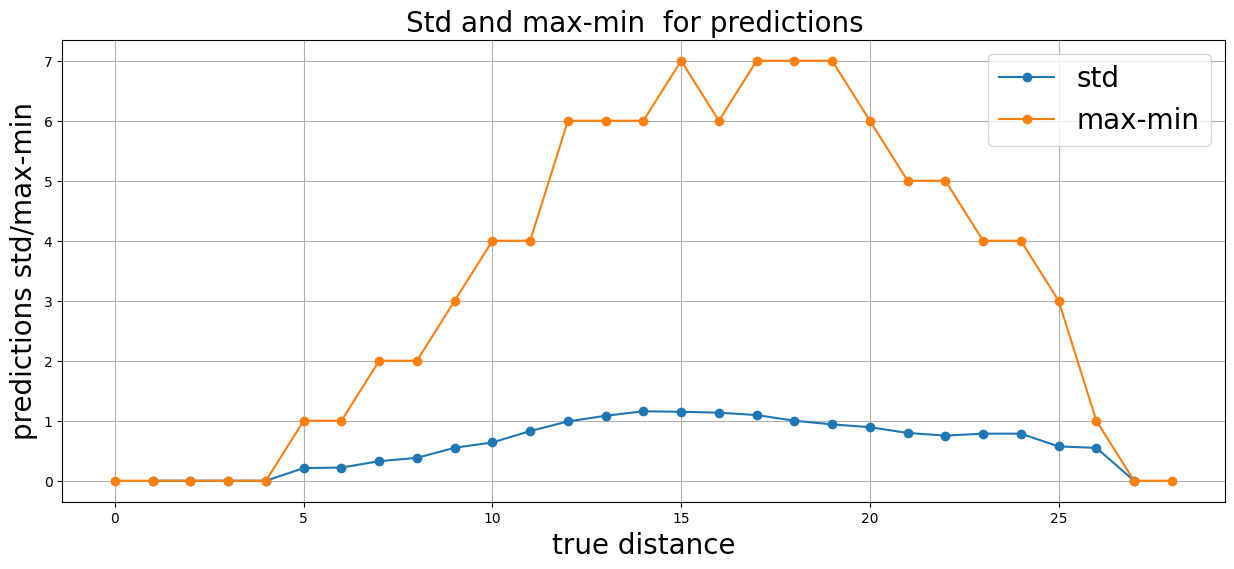

<timed exec>:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


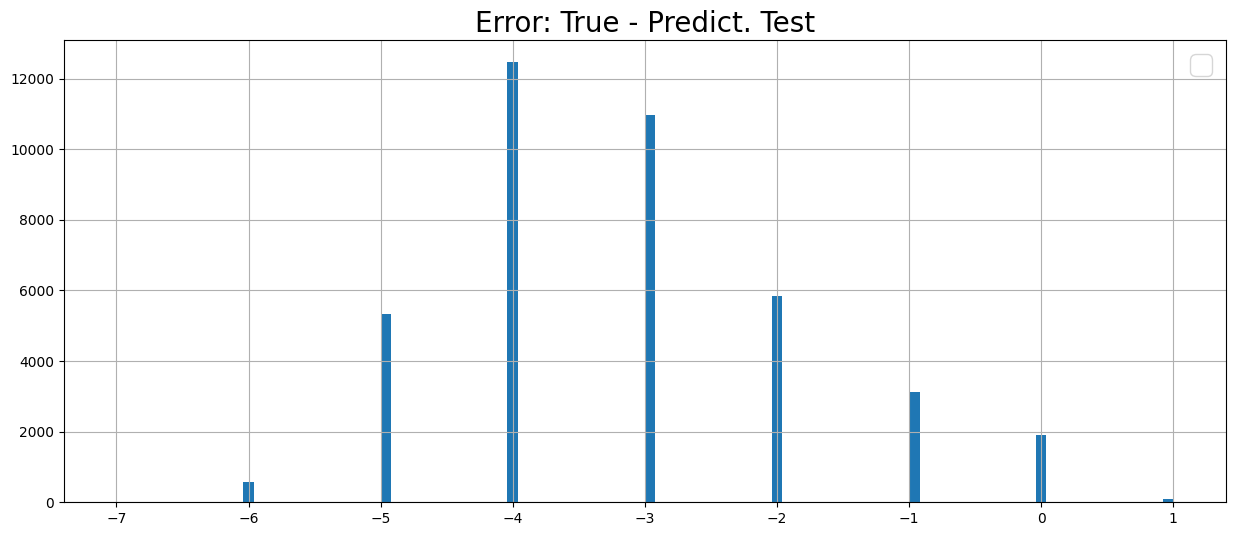

TypeError: got an unexpected keyword argument 'squared'

In [38]:
%%time

# # Take all states constructed by BFS - convert them to torch tensor
# all_states = torch.zeros( size = (len(list_all_states), list_all_states[0].shape[0] ),  dtype =dtype, device = device )
# for k in range(len(list_all_states)):
#     all_states[k,:] = list_all_states[k]

all_states = array_states_all_saved
list_distances = list_distances_save


# Compute their neigbours
neigb = get_neighbors(all_states, tensor_generators)
# print( neigb.shape )
      
# Compute model predictions
y_pred = torch.zeros( (neigb.shape[0],neigb.shape[1],1 ), device =device   )
batch_size_loc = 1024
model.eval()
with torch.no_grad():
    for i_batch in range(0,neigb.shape[0], batch_size_loc ):
        i_end_batch = min( [i_batch+batch_size_loc ,neigb.shape[0]] )
        y_pred[i_batch:i_end_batch,:,:] = model(neigb[i_batch:i_end_batch,:,:])# .view(-1, 8) )
# print( y_pred.shape )

# Bellman's equation / Q-learning for graphs update: 
# V(g) = 1 + min_{neigb} V (neigb ) 
y_pred = 1 + torch.min(y_pred, dim=1)[0]

# Clip everthing to 1 and origin to 0
y_pred = torch.clamp_min(y_pred, 1 ) 
# Boundary condition - origin is in zero: 
y_pred[0]=0

# Rounding - since true distance is integer - but it does not seem to improve 
y_pred = torch.round(y_pred)



#######################################################################################
# Plots for error analysis
#######################################################################################

y_pred = y_pred.detach().cpu().numpy().ravel() #  =  convert_to_numpy( y_pred  ,y_pred ) 
y_test = np.array( list_distances )

plt.figure(figsize=(15,6))
plt.plot(y_pred )
plt.title('Predictions ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('index',fontsize = 20 )
plt.grid()
plt.show()

d = pd.DataFrame()
d['pred'] = y_pred
d['true'] = y_test
res = d.groupby('true')['pred'].agg(['mean', 'min', 'max'])
st = d.groupby('true')['pred'].agg(['std'])
plt.figure(figsize=(15,6))
plt.plot(res, 'o-',label = res.columns )
plt.plot(res['mean']+st['std'], 'o-',label = 'mean+std' )
plt.plot(res['mean']-st['std'], 'o-',label = 'mean-std' )
plt.title('Predictions vs true distance ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions',fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(st['std'], 'o-', label = 'std' )
plt.plot(res['max']-res['min'],'o-', label = 'max-min' )
plt.title('Std and max-min  for predictions  ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions std/max-min',fontsize = 20 )
plt.grid()
plt.show()

y_true = y_test
er = y_true - y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
spearmanr_test = stats.spearmanr(y_test, y_pred).statistic
pearson_test = np.corrcoef(y_test, y_pred)[0,1]
#res.statistic


df_stat = pd.DataFrame()
IX = len(df_stat)+1

df_stat.loc[IX,'Model'] = str_modeling_inf
# df_stat.loc[IX,'r2 Test'] = r2_test
#df_stat.loc[IX,'r2 Train'] = r2_train
# df_stat.loc[IX,'rmse Test'] = rmse_test
#df_stat.loc[IX,'rmse Train'] = rmse_train
df_stat.loc[IX,'Spearman'] = spearmanr_test
df_stat.loc[IX,'Pearson'] = pearson_test
#df_stat.loc[IX,'Spearman Train'] = spearmanr_train
#df_stat.loc[IX,'FitTime'] = np.round(fit_time,3)
df_stat.loc[IX,'PredictTime'] = np.round(predict_time,3)
#df_stat.loc[IX,'Train'] = str(X_train.shape)
df_stat.loc[IX,'Test'] = str(X_test.shape)

df_stat.round(3)

# Modified DQN training 

In [39]:
%%time
n_epochs_dqn = CFG['n_epochs_dqn']
flag_dqn_round = CFG['flag_dqn_round']
n_random_walks_to_generate = CFG['n_random_walks_to_generate_dqn']
print('n_epochs:', n_epochs_dqn)
verbose_loc = 10
t1 = time.time()
if n_epochs_dqn > 0:
    
    i_epoch_best = 0
    list_epoch_train_loss = []
    for epoch in range(n_epochs_dqn):
        #    torch.cuda.empty_cache()
        tt0 = time.time()
        X_train, y_train = random_walks(list_generators, n_random_walk_length=n_random_walk_length, 
                                        n_random_walks_to_generate=n_random_walks_to_generate, 
                                        n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban, 
                                        random_walks_type = random_walks_type, #'simple', 
                                        state_rw_start = state_destination)

        if verbose_loc >= 100:
            print('Epoch:', epoch ,  'RW-Generation Time: %.1f'%(time.time() - tt0) )
        t_rw = time.time() - tt0

        
        # Compute their neigbours
        neigb = get_neighbors(X_train, tensor_generators)
        # print( neigb.shape )

        # Compute model predictions by batches, and Bellman's equation update
        tt0 = time.time()
        n_states_all = X_train.shape[0]
        y_bellman = torch.zeros(X_train.shape[0], device = device, dtype = torch.float  )
        model.eval()
        with torch.no_grad():
            for i_start_batch  in range(0,n_states_all,batch_size ):
                i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )   
                y_pred = model(neigb[i_start_batch:i_end_batch,:,:])# .view(-1, 8) )
                # Bellman:
                y_pred = 1 + torch.min(y_pred, dim=1)[0]
                # Store results:
                y_bellman[i_start_batch:i_end_batch] = y_pred.reshape(-1,)
                
        # Boundary conditions and restrictions coming from the diffusion distance 
        # Сliping (which also partly induce boundary conditions - they will be set to values less than zero - we need exactly zero ) 
        y_train = torch.min( y_bellman, y_train  )
        # Clip everthing to 1 and 
        y_train = torch.clamp_min(y_train, 1 ) 
        # Boundary condition - at origin distance is zero: 
        # (It is not complete boundary condition - since there can be other states which come to origin after many steps ) 
        y_train[:n_random_walks_to_generate] = 0
        # Rounding since distances are integers positive numbers: 
        #flag_dqn_round = 1
        if flag_dqn_round:
            y_train = torch.round( y_train )
        
        if verbose_loc >= 100:
            print('Epoch:', epoch ,  'Bellman Time: %.2f'%(time.time() - tt0) )
        t_bellman = time.time() - tt0

        
        # Shuffle train data and 
        #y_train = y_train.float()
        indices = torch.randperm(X_train.shape[0])
        X_train = X_train[indices] 
        y_train = y_train[indices] 

        
        tt0 = time.time()
        model.train()
        # Neural network train by batches (not to crash RAM)
        n_states_all =  X_train.shape[0]
        cc = 0; train_loss = 0.0
        for i_start_batch  in range(0,n_states_all,batch_size ):
            i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
            
            # Forward
            outputs = model(X_train[i_start_batch:i_end_batch])
            loss = criterion(outputs.squeeze(), y_train[i_start_batch:i_end_batch])
            
            # Backward and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item(); 
            cc+=1
        train_loss /= cc
        list_epoch_train_loss.append( train_loss )
        t_train = time.time() - tt0

        if verbose_loc >= 100:
            print('Epoch:', epoch ,  'Optimize Time: %.2f'%(time.time() - tt0) )

            print('epoch:', epoch ,'train_loss:', np.round(train_loss,4),'Time:', np.round(time.time()-t1,2) )

        if verbose_loc >= 10:
            if epoch% (verbose_loc) == 0:
                print('epoch:', epoch ,'train_loss:', np.round(train_loss,4),'Time:', np.round(time.time()-t1,2),
                     'RW %.2f'%(t_rw),'Bellman %.2f'%(t_bellman),'Train %.2f'%(t_train),    )

    print('Training finished. Timing:', np.round(time.time()-t1, 1) )

n_epochs: 5000
epoch: 0 train_loss: 1.1849 Time: 0.11 RW 0.05 Bellman 0.02 Train 0.05
epoch: 10 train_loss: 0.0859 Time: 1.04 RW 0.04 Bellman 0.01 Train 0.03
epoch: 20 train_loss: 0.0565 Time: 1.98 RW 0.04 Bellman 0.01 Train 0.03
epoch: 30 train_loss: 0.0469 Time: 2.9 RW 0.04 Bellman 0.01 Train 0.03
epoch: 40 train_loss: 0.0377 Time: 3.82 RW 0.04 Bellman 0.01 Train 0.04
epoch: 50 train_loss: 0.0334 Time: 4.76 RW 0.04 Bellman 0.01 Train 0.03
epoch: 60 train_loss: 0.0309 Time: 5.68 RW 0.04 Bellman 0.01 Train 0.03
epoch: 70 train_loss: 0.0277 Time: 6.61 RW 0.04 Bellman 0.01 Train 0.04
epoch: 80 train_loss: 0.025 Time: 7.53 RW 0.04 Bellman 0.01 Train 0.03
epoch: 90 train_loss: 0.0226 Time: 8.47 RW 0.04 Bellman 0.01 Train 0.03
epoch: 100 train_loss: 0.0216 Time: 9.4 RW 0.04 Bellman 0.01 Train 0.03
epoch: 110 train_loss: 0.0205 Time: 10.32 RW 0.04 Bellman 0.01 Train 0.03
epoch: 120 train_loss: 0.018 Time: 11.24 RW 0.04 Bellman 0.01 Train 0.03
epoch: 130 train_loss: 0.0158 Time: 12.18 RW 0.04

In [40]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(notebook_dir)

In [41]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.app import PermutationSolver


In [42]:
n = 8
config = {
            'n_permutations_length': n,
            
            # Random walks params
            'random_walks_type': 'non-backtracking-beam',
            'n_random_walk_length': int(n * (n-1) / 2),
            'n_random_walks_to_generate': 1000,
            'n_random_walks_steps_back_to_ban': 8,
            
            # Neural Net params
            'model_type': 'MLP',
            'list_layers_sizes': [2**12],
            'n_epochs': 100,
            'batch_size': 1024,
            'lr_supervised': 0.001,
            
            # DQN training
            'n_epochs_dqn': 16000,
            'flag_dqn_round': False,
            'n_random_walks_to_generate_dqn': 1000,
            'verbose_loc': 50,
            'lr_rl': 0.001,
            
            # Beam search
            'beam_search_torch': True,
            'beam_search_Fironov': False,
            'beam_width': 1,
            'n_steps_limit': 4 * n**2,
            'alpha_previous_cost_accumulation': 0,
            'beam_search_models_or_heuristics': 'model_torch',
            'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False,
            'n_beam_search_steps_back_to_ban': 32,
            
            # What to solve
            'solve_random_or_longest_state': 'solve_LRX_longest',
            'verbose': 100
        }

solver = PermutationSolver(config)

In [43]:
solver._init_rw_generators()

In [44]:
X_anchor, y_anchor = solver.generate_training_data_anchor()

40320
X.shape: torch.Size([40320, 8])
y.shape: torch.Size([40320])


In [45]:
y_valid = model(X_anchor)

In [46]:
diff = y_anchor.cpu().detach().numpy() - y_valid.cpu().detach().numpy().reshape(1, -1)[0]
min_diff = diff.min()
max_diff = diff.max()
std_diff = diff.std()
mean_diff = diff.mean()
num_elements_less_than_minus_05 = (diff < -0.5).sum()
num_elements_larger_than_05 = (diff > 0.5).sum()
wrong_predictions = num_elements_less_than_minus_05 + num_elements_larger_than_05
percentage_wrong_predictions = wrong_predictions / len(diff)

In [47]:
min_diff

np.float64(-0.14323043823242188)

In [48]:
max_diff

np.float64(0.5334491729736328)

: 

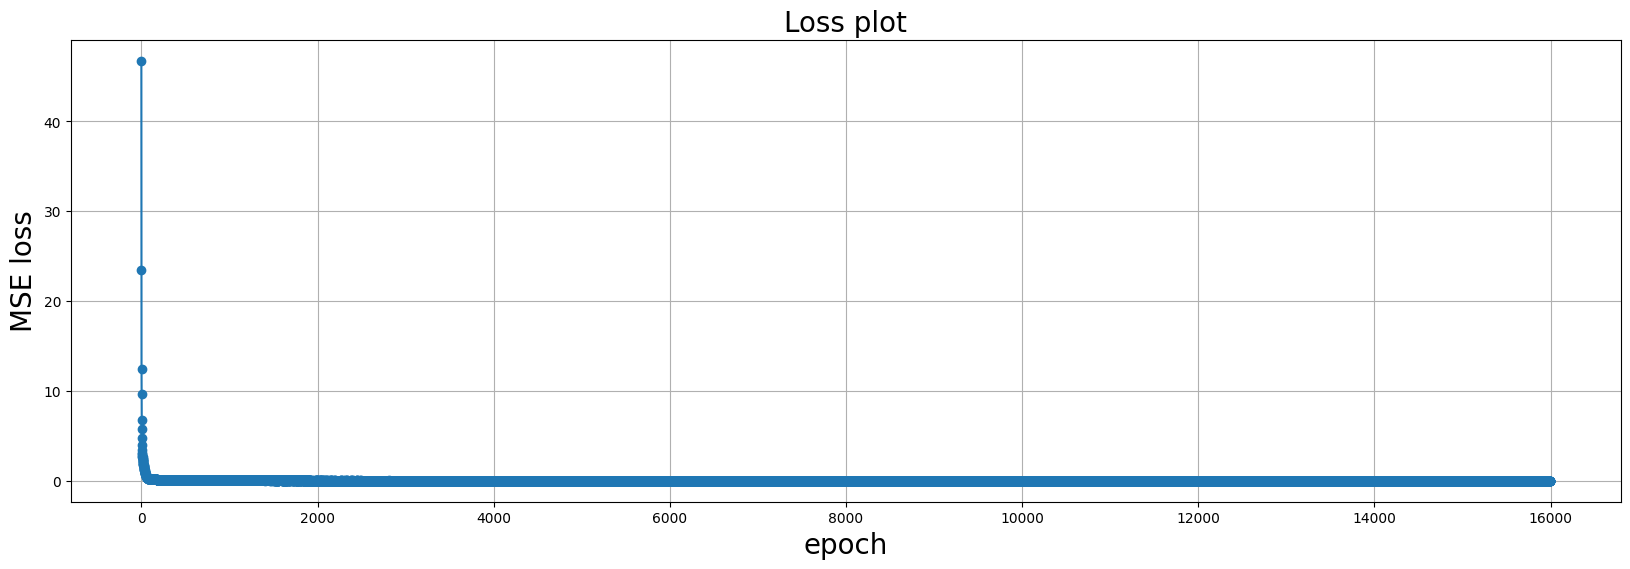

In [39]:
fig = plt.figure(figsize = (20,6 ) )
plt.plot( list_epoch_train_loss, 'o-'  )
plt.title('Loss plot', fontsize = 20 )
plt.xlabel('epoch',fontsize = 20 )
plt.ylabel('MSE loss', fontsize=20)
plt.grid()
plt.show()

<timed exec>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


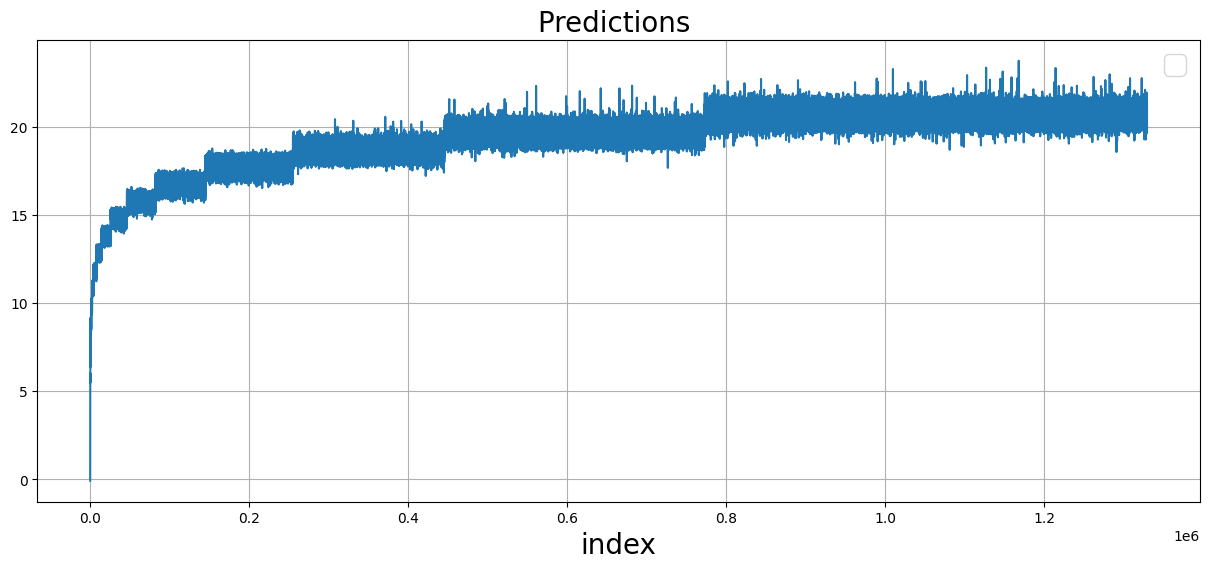

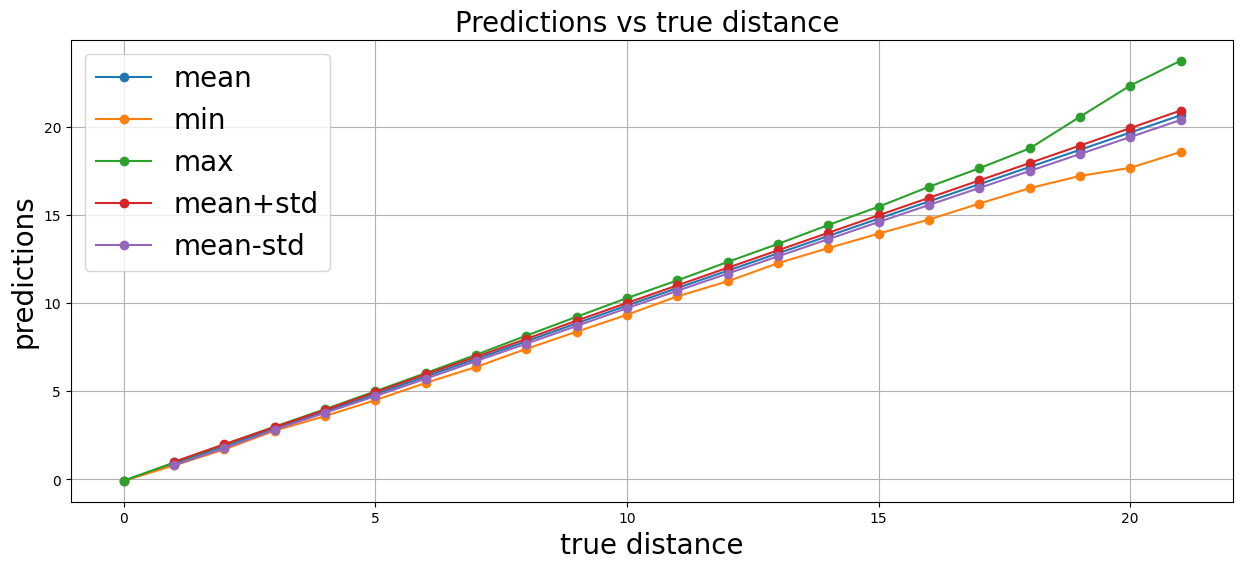

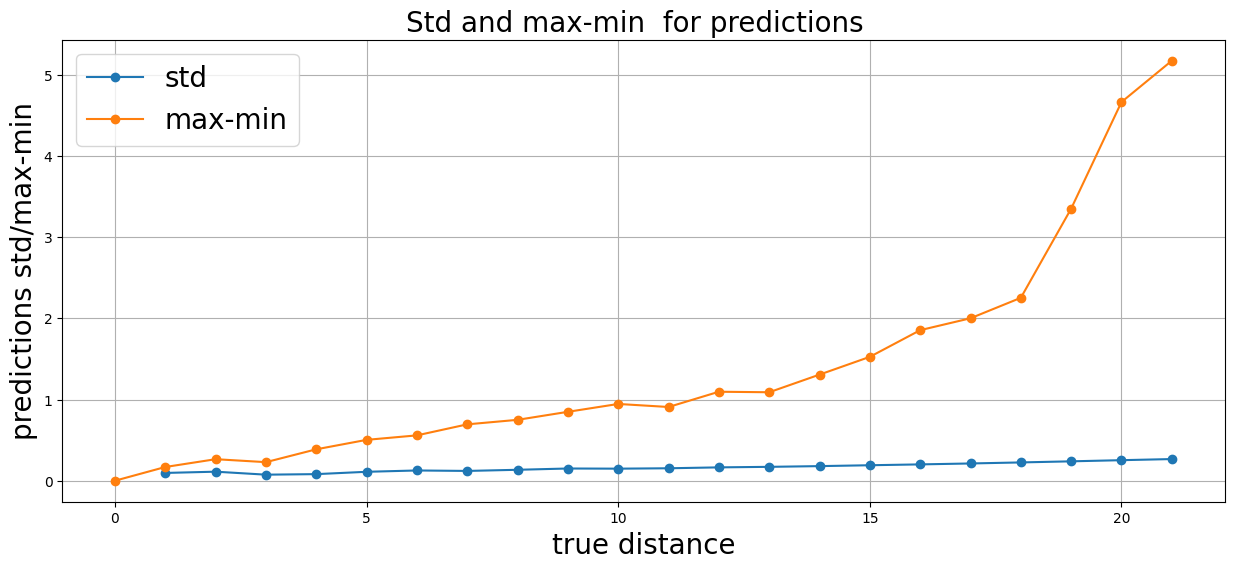

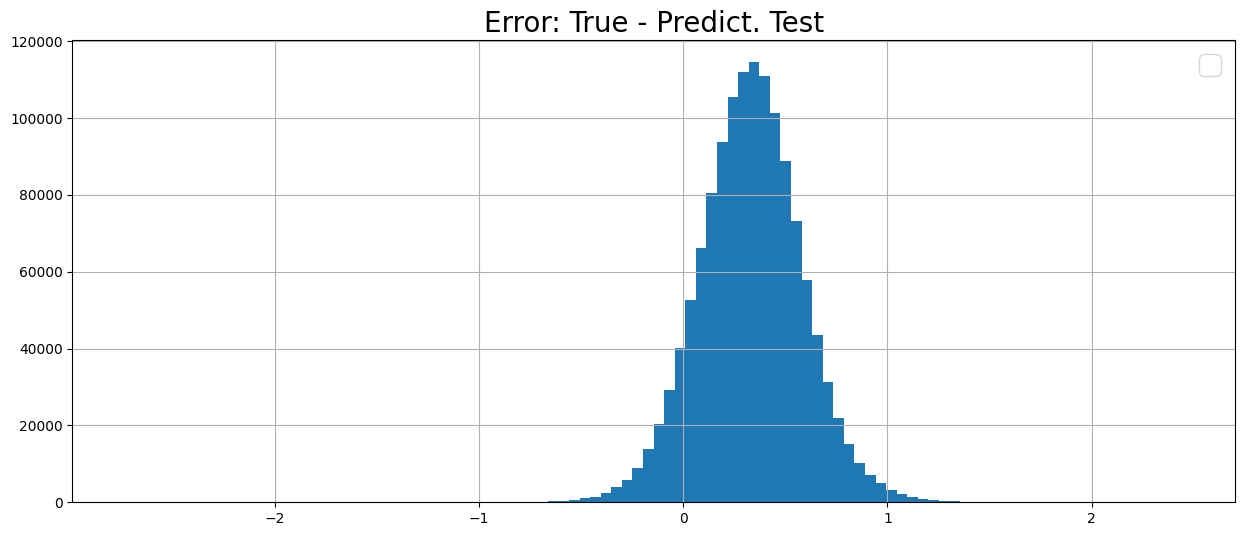

CPU times: user 8.76 s, sys: 19.6 ms, total: 8.78 s
Wall time: 8.69 s


,Model,Spearman,Pearson,PredictTime,Test
1,MLP_4096_epochs100_rwlen120_n_rw1000,0.95,0.99,0.553,"torch.Size([120, 16])"


In [40]:
%%time
# all_states = torch.zeros( size = (len(list_all_states), list_all_states[0].shape[0] ),  dtype =dtype, device = device )
# for k in range(len(list_all_states)):
#     all_states[k,:] = list_all_states[k]


all_states = array_states_all_saved
list_distances = list_distances_save

all_states_tensor = torch.tensor(all_states, dtype=torch.float32)
dataset = TensorDataset(all_states_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Batched prediction
model.eval()
y_pred_list = []

with torch.no_grad():
    for batch in dataloader:
        batch_states = batch[0].to(device) 
        batch_pred = model(batch_states)
        y_pred_list.append(batch_pred.detach().cpu())


y_pred = torch.cat(y_pred_list).numpy().ravel()
y_test = np.array(list_distances)

#######################################################################################
# Plots for error analysis
#######################################################################################

# y_pred = y_pred.detach().cpu().numpy().ravel() #  =  convert_to_numpy( y_pred  ,y_pred ) 
# y_test = np.array( list_distances )

plt.figure(figsize=(15,6))
plt.plot(y_pred )
plt.title('Predictions ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('index',fontsize = 20 )
plt.grid()
plt.show()

d = pd.DataFrame()
d['pred'] = y_pred
d['true'] = y_test
res = d.groupby('true')['pred'].agg(['mean', 'min', 'max'])
st = d.groupby('true')['pred'].agg(['std'])
plt.figure(figsize=(15,6))
plt.plot(res, 'o-',label = res.columns )
plt.plot(res['mean']+st['std'], 'o-',label = 'mean+std' )
plt.plot(res['mean']-st['std'], 'o-',label = 'mean-std' )
plt.title('Predictions vs true distance ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions',fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(st['std'], 'o-', label = 'std' )
plt.plot(res['max']-res['min'],'o-', label = 'max-min' )
plt.title('Std and max-min  for predictions  ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.xlabel('true distance',fontsize = 20 )
plt.ylabel('predictions std/max-min',fontsize = 20 )
plt.grid()
plt.show()

y_true = y_test
er = y_true - y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
spearmanr_test = stats.spearmanr(y_test, y_pred).statistic
pearson_test = np.corrcoef(y_test, y_pred)[0,1]
#res.statistic


df_stat = pd.DataFrame()
IX = len(df_stat)+1

df_stat.loc[IX,'Model'] = str_modeling_inf
# df_stat.loc[IX,'r2 Test'] = r2_test
#df_stat.loc[IX,'r2 Train'] = r2_train
# df_stat.loc[IX,'rmse Test'] = rmse_test
#df_stat.loc[IX,'rmse Train'] = rmse_train
df_stat.loc[IX,'Spearman'] = spearmanr_test
df_stat.loc[IX,'Pearson'] = pearson_test
#df_stat.loc[IX,'Spearman Train'] = spearmanr_train
#df_stat.loc[IX,'FitTime'] = np.round(fit_time,3)
df_stat.loc[IX,'PredictTime'] = np.round(predict_time,3)
#df_stat.loc[IX,'Train'] = str(X_train.shape)
df_stat.loc[IX,'Test'] = str(X_test.shape)

df_stat.round(3)

# State to be solved

In [41]:
%%time
#state_destination = torch.arange( len(list_generators[0] ), dtype = dtype, device = device )
print('state_destination:', state_destination)

# solve_random_or_longest_state = 'solve_random_LRX_longest'
# solve_random_or_longest_state = 'solve_random_state'
solve_random_or_longest_state = CFG['solve_random_or_longest_state']
print('solve_random_or_longest_state:',solve_random_or_longest_state)
if solve_random_or_longest_state == 'solve_random_state':
    n_scrambles_starting_state = len(list_generators)**3*100 #1000 
    state_start = state_destination.clone()
    for k in range(n_scrambles_starting_state):
        IX_move = np.random.randint(0, len(list_generators), dtype = int) # random moves indixes
        state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ] 
else:
    n = len(list_generators[0])
    p = np.arange(n)
    # Swap (0,2)
    p[0], p[1] = p[1], p[0]
    i = 2
    while i < n-i+1:
        #print(i, n-i+1)
        p[i], p[n-i+1] = p[n-i+1], p[i]
        i += 1
    permutation_longest = torch.tensor( p , dtype = dtype, device = device )    
    state_start = permutation_longest 
    print('permutation_LRX_longest:', permutation_longest)

#print('state_destination:', state_destination)
print('state_start (state to be solved): ', state_start)


state_destination: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')
solve_random_or_longest_state: solve_LRX_longest
permutation_LRX_longest: tensor([ 1,  0, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
       device='cuda:0', dtype=torch.uint8)
state_start (state to be solved):  tensor([ 1,  0, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
       device='cuda:0', dtype=torch.uint8)
CPU times: user 3.92 ms, sys: 1 ms, total: 4.92 ms
Wall time: 4.86 ms


# Beam Search Torch

In [42]:
def get_unique_states(states: torch.Tensor, vec_hasher = 'Auto',device = 'Auto') -> torch.Tensor:
    '''
    Return matrix with unique rows for input matrix "states" 
    I.e. duplicate rows are dropped.
    For fast implementation: we use hashing via scalar/dot product.
    Note: output order of rows is different from the original. 

    Note: that implementation is 30 times faster than torch.unique(states, dim = 0) - because we use hashes  (see K.Khoruzhii: https://t.me/sberlogasci/10989/15920)
    Note: torch.unique does not support returning of indices of unique element so we cannot use it 
    That is in contrast to numpy.unique which supports - set: return_index = True     
    '''

    if vec_hasher == 'Auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
        
    # Preprare vector which will used for hashing - to avoid revisiting same states 
    if vec_hasher == 'Auto':
        max_int =  int( (2**62) )
        dtype_for_hash = torch.int64
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)     
    
    # Hashing rows of states matrix: 
    hashed = torch.sum(vec_hasher * states, dim=1) # Compute hashes. 
        # It is same as matrix product torch.matmul(hash_vec , states ) 
        # but pay attention: such code work with GPU for integers 
        # While torch.matmul - does not work for GPU for integer data types, 
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication 
    
    # Sort
    hashed_sorted, idx = torch.sort(hashed)
    # Mask selects elements which are different from the consequite - that is unique elements (since vector is sorted on the previous step)
    mask = torch.concat((torch.tensor([True], device = device), 
                         (hashed_sorted[1:] - hashed_sorted[:-1]) != 0))
    return states[idx][mask]

# Test run:
s = get_unique_states(torch.arange(n_permutations_length, device = device ).view(1, -1  ).expand(10, -1 ).clone())
print(s)
s.shape,s.dtype

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]],
       device='cuda:0')


(torch.Size([1, 16]), torch.int64)

## Beam search params

In [43]:
%%time
print(CFG)
print()
##################################################################################
# Beam search params
##################################################################################


#beam_width = 1000
beam_width =  CFG['beam_width']
print('beam_width:', beam_width)
# Coefficient to combine previous cost and new value typically 0...1 (attenuation of history) 
alpha_previous_cost_accumulation = CFG['alpha_previous_cost_accumulation']
print('alpha_previous_cost_accumulation:', alpha_previous_cost_accumulation  )
# Maximum steps to make:
n_steps_limit = CFG['n_steps_limit']
print('n_steps_limit:',n_steps_limit)

ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted = CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted']
print('ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:',ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted)
beam_search_models_or_heuristics = CFG['beam_search_models_or_heuristics']#  'model_torch'; # 'Hamming'
print('beam_search_models_or_heuristics:',beam_search_models_or_heuristics)
batch_size = CFG['batch_size']
print('batch_size:', batch_size )
n_steps_back_to_ban = CFG['n_beam_search_steps_back_to_ban']
print('n_steps_back_to_ban:',n_steps_back_to_ban)
beam_search_models_or_heuristics = CFG['beam_search_models_or_heuristics']#  'model_torch'; # 'Hamming', 'model_with_predict': # Catboost or Sklearn 
print('beam_search_models_or_heuristics:',beam_search_models_or_heuristics)
 

# To implement ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted
# We need the following to known where what is the position of transposition (0,1) in list_generators
state_size = len(list_generators[0])
#X_loc = torch.tensor( [1,0] + list(np.arange(2,state_size)), device = device, dtype = dtype )
X_loc = np.array( [1,0] + list(np.arange(2,n)) )
i_position_X_in_list_generators = -1
for k in range(len(list_generators)):
    if np.all( list_generators[k] == X_loc ) : 
        i_position_X_in_list_generators = k
        break
print('i_position_X_in_list_generators:',i_position_X_in_list_generators )     
verbose = 100

print()


print('state_destination:', state_destination)
print()
print('state_start (state to be solved): ', state_start)
print()

{'n_permutations_length': 16, 'random_walks_type': 'non-backtracking-beam', 'n_random_walk_length': 120, 'n_random_walks_to_generate': 1000, 'n_random_walks_steps_back_to_ban': 8, 'model_type': 'MLP', 'list_layers_sizes': [4096], 'n_epochs': 100, 'batch_size': 1024, 'lr': 0.001, 'optimizer_type': 'Adam', 'weight_decay': 1e-05, 'scheduler': False, 'n_epochs_dqn': 16000, 'flag_dqn_round': False, 'n_random_walks_to_generate_dqn': 1000, 'beam_search_torch': True, 'beam_search_Fironov': False, 'beam_width': 1, 'n_steps_limit': 1024, 'alpha_previous_cost_accumulation': 0, 'beam_search_models_or_heuristics': 'model_torch', 'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False, 'n_beam_search_steps_back_to_ban': 32, 'solve_random_or_longest_state': 'solve_LRX_longest'}

beam_width: 1
alpha_previous_cost_accumulation: 0
n_steps_limit: 1024
ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted: False
beam_search_models_or_heuristics: model_torch
batch_size: 1024
n_steps_back_to_ban: 32


## Beam search torch main loop

In [44]:
%%time
if CFG['beam_search_torch']:

    n_generators = len(list_generators)
    
    t0 = time.time()
    
    flag_found_destination = False
    
    
    if 1:
        # Initialize array of states 
        array_beam_states = state_start.view(1, state_size  ).clone().to(dtype).to(device)
    
    
        # Hash initial states. Intialize storage
        if n_steps_back_to_ban > 0:
            # Hashes via vector product - extremely simple and fast
            # Implementation - equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
            hash_initial_state = torch.sum( state_start.view(-1, state_size  ) * vec_hasher, dim=1) # Compute hashes 
            # Storage for hashes - 2d array: 
            vec_hashes_current = hash_initial_state.expand( beam_width * n_generators  , n_steps_back_to_ban ).clone()
            # Intialize index for hash storage
            # Newly obtained hash vectors will be stored in 2d array vec_hashes_current 
            # The position/column for storage: i_cyclic_index_for_hash_storage
            i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_steps_back_to_ban, i.e. from 0 to n_steps_back_to_ban-1
    
        ##########################################################################################
        # Main loop 
        # 1. Apply all moves to all states in current beam - get new states candidates
        # 2. Select only unique states - that appears to be critical - otherwise beam becomes over-populated by duplicates and all the diversity ideas is lost
        # 3. Check  destination-state:  found or not
        # 4. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
        # 4.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
        # 4.2. Choose only those states which hashes are new - not in the stored history of hashes
        # 5 Compute value function for all states - model prediction or heuristics
        # 5b Select only desired number of states - beam_width "best" states 
        ##########################################################################################    
        for i_step in range(1,n_steps_limit+1):
            t_moves = t_hash = t_isin =  0; t_full_step = time.time() # Time profiling
            t_unique_els = 0 
            
            # 1. Create new states: 
            # Apply all generators to all current states at once
            # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
            t1 = time.time()
            if not ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:
                array_new_states = get_neighbors(array_beam_states,tensor_generators  ).flatten(end_dim=1) # Flatten converts 3d array to 2d
            
            else:
                # Basically same as above - result will be application of all moves to all beam states
                # but do it move by move, in order to check specific heuristic condition for some moves
                # I.e. implement  "Fironov's X-condition check"
                # That is not apply transposition (0,1) if v[0],v[1] are already sorted 
    
                # Prepare storage for new states: 
                array_new_states = torch.empty( (0,array_beam_states.shape[1]) , device=device, dtype = dtype)
                
                # Technical preparation: to apply permutations to array we need the trick:
                # naively it is: array[ :, IX_array], but actually we need  to write array[ range(N)[:, np.newaxis], IX_array  ]
                row_indices = np.arange( array_beam_states.shape[0] )[:, np.newaxis]
                
                # Loop over moves:
                for ii1, move in enumerate(list_generators):
                    
                    if (ii1 != i_position_X_in_list_generators):
                        # Make move - one move to all beam states at once: 
                        array_states_tmp = array_beam_states[row_indices,move]
                        
                    else:
                        # Make moves with exceptions: 
                        # Do not make transposition of 0,1 if they are already sorted:
                        mask_X_condtion = array_beam_states[:,0] > array_beam_states[:,1]
                        row_indices = np.arange( mask_X_condtion.sum().item() )[:, np.newaxis]
                        array_states_tmp = array_beam_states[mask_X_condtion][row_indices,move]
                   
                    # array_states_tmp = get_unique_states(array_states_tmp) # Do this later - Can do it for all states at once later for speed-up
                    
                    array_new_states = torch.concatenate([array_new_states, array_states_tmp],axis = 0)
            
            t_moves += (time.time() - t1)
    
            # 2. Take only unique states 
            # surprise: THAT IS CRITICAL for beam search performance !!!!
            # if that is not done - beam search  will not find the desired state - quite often
            # The reason - essentianlly beam can degrade, i.e. can be populated by copy of only one state 
            # It is surprising that such degradation  happens quite often even for beam_width = 10_000 - but it is indeed so          
            t1 = time.time()
            array_new_states = get_unique_states(array_new_states)
            t_unique_els += (time.time() - t1)
            
            # 3. Check destination state found 
            vec_tmp = torch.all(array_new_states == state_destination, axis =1) # Compare state_destination and each row array_of_states 
            flag_found_destination = torch.any(vec_tmp).item() # Check for coincidence
            if flag_found_destination:
                if verbose >= 1:
                    print('Found destination state. ', 'i_step:', i_step, ' n_ways:', (vec_tmp).sum()) 
                break   
            
            # 4. Nonbacktracking - forbid visits states visited before
            if n_steps_back_to_ban > 0:      
                # 4.1 Compute hashes
                # Compute hash. For non-backtracking, i.e. selection of  states, which were not visited  before. 
                t1 = time.time()
                vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes 
                # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
                t_hash += (time.time() - t1)
                #  print('hashed', t_hash )
    
                # 4.2 Select only states not seen before
                # Nonbacktracking - select states not visited before 
                t1 = time.time()
                mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
                t_isin += (time.time() - t1)
                mask_new_sum = mask_new.sum().item()
                if mask_new_sum > 0 :
                    # Select only new states - not visited before
                    array_new_states = array_new_states[mask_new,:]
                else:
                    # Stagnation cannot find new states 
                    # In futute versions consider restarts 
                    flag_found_destination = False 
                    # i_step = -1
                    if verbose >= 1:
                        print('Cannot find new states. i_step:',i_step, )
                    break
                # Update hash storage 
                # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
                # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
                # Which might not always be the case since random walk may create loops. 
                # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
                # Thus we improve chances that the next states will increase the true graph distance
                i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_steps_back_to_ban
                i_tmp = len(vec_hashes_new)
                vec_hashes_current[:i_tmp, i_cyclic_index_for_hash_storage ] = vec_hashes_new  
    
            # 5. Estimate states and select top beam_width ones 
            # ML-model inference - estimate distance of new states to the destination state    
            t0 = time.time()
            q_value = torch.tensor([0])
            if array_new_states.shape[0] > beam_width: # If we have not so many states - we take them all - no need for ML-model
    
                # Compute heuristic distance to destination state
                if beam_search_models_or_heuristics == 'model_torch': 
                    model.eval()
                    with torch.no_grad():
                        n_states_all = array_new_states.shape[0]
                        q_value = torch.zeros( n_states_all, device = device )
                        for i_start_batch  in range(0,n_states_all,batch_size ):     
                            i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
                            q_value[i_start_batch:i_end_batch]  = model(array_new_states[i_start_batch:i_end_batch ,: ]).view(-1)
                    # Get indices of the smallest `beam_width` values
                    idx = torch.argsort(q_value)[:beam_width]
                    # Select rows based on the indices
                    array_beam_states = array_new_states[idx, :]
                elif beam_search_models_or_heuristics == 'model_with_predict': # Catboost or Sklearn 
                
                    # ML-model inference - estimate distance of new states to the destination state
                    q_value = model.predict(array_new_states.detach().cpu().numpy() )
                    # Take only "beam_width" of the best states (i.e. most nearest to destination according to the model estimate)
                    idx = np.argsort(q_value)[:beam_width]
                    array_beam_states = array_new_states[idx,:]
                    
                elif beam_search_models_or_heuristics == 'Hamming': 
                    # Here it is Hamming distance, but can be neural net predictor:
                    q_value = torch.sum( (array_new_states - state_destination ) !=0 , axis = 0 )
                    # Get indices of the smallest `beam_width` values
                    idx = torch.argsort(q_value)[:beam_width]
                    # Select rows based on the indices
                    array_beam_states = array_new_states[idx, :]                
                else:
                    raise Exception("Unrecognized models_or_heuristics: " + str( beam_search_models_or_heuristics ))
                    
            else:
                array_beam_states = array_new_states
            predict_time = time.time() - t0        
    
            if verbose >= 10:
                if (i_step-1) % 10 == 0:
                    if isinstance(q_value, torch.Tensor): q_value = q_value.detach().cpu().numpy()
                    t_full_step = time.time()-t_full_step
                    print('Step:',i_step, #  'Visited states:', len(set_seen_states), 
                          'Beam (not cummulative) min:',  '%.2f'%np.min( q_value),
                          'median:',  '%.2f'%np.median( q_value),
                          'max:',  '%.2f'%np.max( q_value))
            if verbose >= 100:
                if (i_step-1) % 15 == 0:
                    print('Time: %.1f'%(time.time() - t0 ),'t_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves , 
                          t_hash , t_isin , t_unique_els, t_full_step))
                      
    
            #raise Exception("Just stop here")
    
    print()
    print(CFG)
    
    print()
    print('beam_width:', beam_width)
    print('n=',len(list_generators[0] ) )
    print('n(n-1)/2=', int(n*(n-1)/2))
    print('Found Path Length:', i_step , 'flag_found_destination:',flag_found_destination, )
    #print(path_found)        

Step: 1 Beam (not cummulative) min: 122.73 median: 125.39 max: 128.00
Time: 0.0 t_moves  0.000, t_hash  0.000, t_isin 0.000, t_unique_els  0.001, t_full_step 0.016
Step: 11 Beam (not cummulative) min: 98.67 median: 99.35 max: 100.03
Time: 0.0 t_moves  0.000, t_hash  0.000, t_isin 0.000, t_unique_els  0.000, t_full_step 1745190561.373
Step: 21 Beam (not cummulative) min: 92.22 median: 93.98 max: 95.73
Step: 31 Beam (not cummulative) min: 84.86 median: 85.89 max: 86.92
Time: 0.0 t_moves  0.000, t_hash  0.000, t_isin 0.000, t_unique_els  0.000, t_full_step 0.001
Step: 41 Beam (not cummulative) min: 77.95 median: 78.05 max: 78.15
Time: 0.0 t_moves  0.000, t_hash  0.000, t_isin 0.000, t_unique_els  0.000, t_full_step 1745190561.421
Step: 51 Beam (not cummulative) min: 65.82 median: 67.07 max: 68.33
Step: 61 Beam (not cummulative) min: 57.75 median: 59.07 max: 60.39
Time: 0.0 t_moves  0.000, t_hash  0.000, t_isin 0.000, t_unique_els  0.000, t_full_step 0.001
Step: 71 Beam (not cummulative) m

# Beam search S.Fironov's version


In [45]:
from collections import deque
# The deque (short for "double-ended queue") class from the collections module. 
# A deque is a list-like data structure optimized for fast appends and pops from both ends.

    # Key Features of deque: 
    # Fast O(1) append and pop operations on both ends (better than lists, which are O(n) for pops from the front).
    # Thread-safe for append/pop operations.
    # Supports max length (maxlen) to act as a circular buffer.

In [46]:
%%time
if CFG['beam_search_Fironov']:  
    t1 = time.time()
    
    ##################################################################################
    # Beam search params
    ##################################################################################
    
    
    #beam_width = 1000
    beam_width =  CFG['beam_width']
    print('beam_width:', beam_width)
    # Coefficient to combine previous cost and new value typically 0...1 (attenuation of history) 
    alpha_previous_cost_accumulation = CFG['alpha_previous_cost_accumulation']
    print('alpha_previous_cost_accumulation:', alpha_previous_cost_accumulation  )
    # Maximum steps to make:
    n_steps_limit = CFG['n_steps_limit']
    print('n_steps_limit:',n_steps_limit)
    
    ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted = CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted']
    
    beam_search_models_or_heuristics = CFG['beam_search_models_or_heuristics']#  'model_torch'; # 'Hamming'
    
    verbose = 100
    
    ##################################################################################
    # Main initializations 
    ##################################################################################
    
    # Main storage data:
    # Priority queue for the beam search; stores tuples of (cumulative cost, path, current state)
    queue_beam = deque([(0, [], state_start )] )
    
    # Set of all previously visited states 
    # We will ban visiting them again 
    set_seen_states = set( )
    set_seen_states.add(str(state_start))
    
    counter_length = 0 # Path length counter 
    flag_path_found = False
    path_found = []
    ##################################################################################
    # Main loop
    ##################################################################################
    while queue_beam: #  continue looping as long as queue is not empty. It should never be empty, unless graph is not conncected and path does not exists
        counter_length += 1
        #print('counter_length',counter_length)
        
        # Select top best states candidates - top-beam-width    
        queue_beam = deque(sorted(list(queue_beam), key=lambda x: x[0])[:beam_width])
    
        # Storage for newly generated states/costs/paths:
        # They will be obtained by applying all moves to all states in beam 
        queue_beam_next = deque()
    
        # That will be used just for monitoring - printing stat on obtained values 
        # Pay attention these are NOT cummulative costs 
        list_beam_q_values_for_monitoring = []
    
        # Loop via current beam:
        for cost, path, current_state in queue_beam:
            #print('cost, path, current_state',cost, path, current_state)
    
            # Loop via all possible moves 
            for i_action, action in enumerate(['L','R','X']):
    
                #Check conditions for reasonable moves, disregard unreasoanble
                # Condition proposed by S.Fironov - it is rather natural, is there theoretical proof ?
                if ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:
                    if action == 'X' and current_state[0] < current_state[1]: # Heuristics 
                        continue            
                if action == 'L' and len(path) > 0 and path[-1] == 'R': # Non-backtracking
                   continue
                if action == 'R' and len(path) > 0 and path[-1] == 'L': # Non-backtracking
                   continue
     
                # Make a move (apply generator, i.e. go to neigbour node )
                generator =  tensor_generators[i_action, : ]
                next_state = current_state[ generator ]
    
                # Check destnation found: 
                if torch.all( next_state == state_destination) :
                    flag_path_found = True
                    path_found = path + [action]
                    break 
    
                # Check the next_state is new or visited before 
                if str(next_state) not in set_seen_states:
                    set_seen_states.add(str(next_state))
    
                    # Compute heuristic distance to destination state
                    if beam_search_models_or_heuristics == 'model_torch': 
                        model.eval()
                        with torch.no_grad():
                            q_value = model(next_state.reshape(1,-1)).item()
    
                    elif beam_search_models_or_heuristics == 'Hamming': 
                        # Here it is Hamming distance, but can be neural net predictor:
                        q_value = torch.sum( (next_state - state_destination ) !=0  ).item()
                    else:
                        raise Exception("Unrecognized models_or_heuristics: " + str( beam_search_models_or_heuristics ))
                    
                    list_beam_q_values_for_monitoring.append(q_value)
    
                    # Cummulative cost: 
                    total_cost = q_value + alpha_previous_cost_accumulation * cost  
                    queue_beam_next.append((total_cost, path + [action], next_state))
                    
                ###### End loop over actions/moves
            
            if flag_path_found: break  # Path found. Stop process
            ###### End loop over beam
        
        if flag_path_found: break  # Path found. Stop process
    
        if verbose >= 100:
            if counter_length % 10 == 0:        
                print('Step:',counter_length, 'Visited states:', len(set_seen_states), 
                      'Beam (not cummulative) min:',  '%.2f'%np.min( list_beam_q_values_for_monitoring),
                      'median:',  '%.2f'%np.median( list_beam_q_values_for_monitoring),
                      'max:',  '%.2f'%np.max( list_beam_q_values_for_monitoring),
                      'Time: %.1f'%(time.time() - t1 ))
                # print('new max len', len(path), len(queue), len(seen), 
                #       np.min(list_beam_q_values_for_monitoring), np.median(list_beam_q_values_for_monitoring),
                #       np.mean(list_beam_q_values_for_monitoring), np.max(list_beam_q_values_for_monitoring) )
            
        
        if counter_length > n_steps_limit:
            flag_path_found = False
            path_found = []
            break
    
    
        # Update the entire queu for new states/costs/paths:
        queue_beam = queue_beam_next
    
        ###### End loop iterations 
    
    print()
    print(CFG)
    
    print()
    print('beam_width:', beam_width)
    print('n=',len(list_generators[0] ) )
    print('n(n-1)/2=', int(n*(n-1)/2))
    print('Found Path Length:', len(path_found)  , 'flag_path_found:',flag_path_found, )
    print(path_found)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


# Check path correctness

In [47]:
if CFG['beam_search_Fironov']:
   
    state = state_start.clone()
    print('state_start:',state_start)
    path = path_found
    for p in path:
        move = dict_generators[p]
        state = state[move]
    print(state)    
    print(state_destination)
    print('Path correct: ', torch.all( state ==  state_destination).item()  )
    
    def solution_checker(dict_generators, state_start, path,  state_destination ):
        state = state_start.clone()
        path = path_found
        for p in path:
            move = dict_generators[p]
            state = state[move]    
        flag_path_correct = torch.all( state ==  state_destination).item()
        return flag_path_correct
    
    flag_path_correct = solution_checker(dict_generators, state_start, path,  state_destination ) 
    print('flag_path_correct:',flag_path_correct)

# Final Timing

In [48]:
print('%.1f seconds passed total '%(time.time()-t0start) )
print('%.1f minutes passed total '%( (time.time()-t0start)/60)  )
print('%.2f hours passed total '%( (time.time()-t0start)/3600)  )

7581.4 seconds passed total 
126.4 minutes passed total 
2.11 hours passed total 
